# Housing Price Prediction using Graph Neural Networks

This notebook implements a comprehensive housing price prediction model using Graph Convolutional Networks (GCN) combined with LSTM for temporal modeling. The model predicts housing prices across London's Lower Layer Super Output Areas (LSOAs) using spatial and temporal dependencies.

## Key Features:
- **Spatial Modeling**: Graph Convolutional Networks to capture spatial relationships between LSOAs
- **Temporal Modeling**: LSTM networks for time series prediction
- **Multi-modal Features**: Integration of economic, social, and infrastructure features
- **Advanced Training**: Bayesian optimization, early stopping, and ensemble methods

## Environment Setup and Dependencies

First, we'll import all necessary libraries and set up the environment for housing price prediction.

In [18]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from sklearn.neighbors import kneighbors_graph

# Optimization libraries
try:
    import optuna
    from optuna.samplers import TPESampler
    HAS_OPTUNA = True
    print("Optuna available for hyperparameter optimization")
except ImportError:
    HAS_OPTUNA = False
    print("Optuna not available. Using default hyperparameters.")

# Data manipulation
from datetime import datetime
import json
import pickle
from typing import Dict, List, Tuple, Optional

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Optuna available for hyperparameter optimization
Using device: cpu
Environment setup complete!
PyTorch version: 2.7.1
Device: cpu


## Configuration and Data Paths

Setting up the configuration for our housing price prediction model with GitHub data sources.

In [19]:
class Config:
    """Configuration class for housing price prediction model"""

    # GitHub Data URLs
    GITHUB_BASE_URL = "https://raw.githubusercontent.com/IflyNY2PR/CASA0004/main"
    HOUSING_DATA_URL = f"{GITHUB_BASE_URL}/data-preparation/economic/housing-value.csv"
    SHAPEFILE_URL = "https://github.com/IflyNY2PR/DSSS_cw/raw/main/statistical-gis-boundaries-london.zip"

    # Local data directory
    DATA_DIR = Path('./housing_data')

    # Model parameters
    SEQUENCE_LENGTH = 12  # Number of time steps to look back
    PREDICTION_HORIZON = 4  # Number of quarters to predict ahead
    HIDDEN_DIM = 128
    NUM_LAYERS = 2
    DROPOUT = 0.3
    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    EPOCHS = 50
    PATIENCE = 10

    # Graph parameters
    K_NEIGHBORS = 8  # Number of nearest neighbors for spatial graph
    SPATIAL_THRESHOLD = 2000  # Distance threshold in meters

    # Training parameters
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

    # Feature engineering
    USE_PCA = True
    PCA_COMPONENTS = 50
    FEATURE_SELECTION_K = 100

config = Config()

# Create output directories
config.DATA_DIR.mkdir(parents=True, exist_ok=True)
save_dir = config.DATA_DIR / 'housing_prediction_results'
save_dir.mkdir(parents=True, exist_ok=True)
model_dir = save_dir / 'models'
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Configuration loaded successfully!")
print(f"Housing data URL: {config.HOUSING_DATA_URL}")
print(f"Results will be saved to: {save_dir}")

Configuration loaded successfully!
Housing data URL: https://raw.githubusercontent.com/IflyNY2PR/CASA0004/main/data-preparation/economic/housing-value.csv
Results will be saved to: housing_data/housing_prediction_results


## Data Loading and Preprocessing

Downloading housing value dataset and shapefiles from GitHub repositories.

In [20]:
import requests
import zipfile
import io

def download_housing_data(force_download=False):
    """Download housing data and shapefiles from GitHub"""

    # Define file paths
    housing_file = config.DATA_DIR / 'housing-value.csv'
    shapefile_dir = config.DATA_DIR / 'shapefiles'
    shapefile_dir.mkdir(exist_ok=True)

    # Check if files already exist
    shapefile_exists = (shapefile_dir / 'statistical-gis-boundaries-london').exists()

    if not housing_file.exists() or force_download:
        print("Downloading housing value data from GitHub...")
        try:
            response = requests.get(config.HOUSING_DATA_URL)
            response.raise_for_status()

            with open(housing_file, 'wb') as f:
                f.write(response.content)
            print(f"✅ Housing data downloaded successfully to {housing_file}")

        except Exception as e:
            print(f"❌ Error downloading housing data: {e}")
            return None, None
    else:
        print(f"Housing data already exists at {housing_file}")

    if not shapefile_exists or force_download:
        print("Downloading London shapefiles from GitHub...")
        try:
            response = requests.get(config.SHAPEFILE_URL)
            response.raise_for_status()

            # Extract zip file
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
                zip_file.extractall(shapefile_dir)
            print(f"✅ Shapefiles downloaded and extracted to {shapefile_dir}")

        except Exception as e:
            print(f"❌ Error downloading shapefiles: {e}")
            return housing_file, None
    else:
        print(f"Shapefiles already exist at {shapefile_dir}")

    # Find the actual shapefile path
    shapefile_path = None
    possible_paths = [
        shapefile_dir / 'statistical-gis-boundaries-london' / 'ESRI' / 'LSOA_2011_London_gen_MHW.shp',
        shapefile_dir / 'ESRI' / 'LSOA_2011_London_gen_MHW.shp',
        shapefile_dir / 'LSOA_2011_London_gen_MHW.shp'
    ]

    for path in possible_paths:
        if path.exists():
            shapefile_path = path
            break

    return housing_file, shapefile_path

# Download the data
print("=== Downloading Housing Data and Shapefiles ===")
housing_file_path, shapefile_path = download_housing_data()

if housing_file_path and housing_file_path.exists():
    # Load housing value data
    print(f"\nLoading housing value data from {housing_file_path}...")
    housing_df = pd.read_csv(housing_file_path, encoding='utf-8-sig')

    print(f"Housing data shape: {housing_df.shape}")
    print(f"Columns: {len(housing_df.columns)}")
    print(f"LSOA areas: {len(housing_df)}")

    # Display basic info
    print("\nFirst few rows:")
    print(housing_df.head())

    print("\nColumn names (first 10):")
    print(housing_df.columns[:10].tolist())

    print("\nData types:")
    print(housing_df.dtypes.head(10))

else:
    print("❌ Failed to download housing data")
    housing_df = None

if shapefile_path and shapefile_path.exists():
    print(f"\nLoading London shapefiles from {shapefile_path}...")
    london_gdf = gpd.read_file(shapefile_path)
    print(f"✅ Loaded {len(london_gdf)} LSOA boundaries")
    print(f"Shapefile columns: {london_gdf.columns.tolist()}")
else:
    print("❌ Shapefile not found, will create synthetic spatial data later")
    london_gdf = None

=== Downloading Housing Data and Shapefiles ===
Housing data already exists at housing_data/housing-value.csv
Shapefiles already exist at housing_data/shapefiles

Loading housing value data from housing_data/housing-value.csv...
Housing data shape: (34753, 112)
Columns: 112
LSOA areas: 34753

First few rows:
   LSOA code        LSOA name Year ending Dec 1995 Year ending Mar 1996  \
0  E01011949  Hartlepool 009A               34,750               34,500   
1  E01011950  Hartlepool 008A               25,000               25,000   
2  E01011951  Hartlepool 007A               27,000               27,000   
3  E01011952  Hartlepool 002A               44,500               44,500   
4  E01011953  Hartlepool 002B               22,000               27,000   

  Year ending Jun 1996 Year ending Sep 1996 Year ending Dec 1996  \
0               30,500               30,000               29,950   
1               25,300               25,625               25,000   
2               27,250             

In [21]:
# Data preprocessing and cleaning
def preprocess_housing_data(df):
    """Preprocess housing value data"""
    # Make a copy
    df_clean = df.copy()

    # Get time columns (exclude LSOA code and name)
    time_columns = [col for col in df_clean.columns if col not in ['LSOA code', 'LSOA name']]

    print(f"Found {len(time_columns)} time periods")
    print(f"Time range: {time_columns[0]} to {time_columns[-1]}")

    # Convert time columns to numeric, handle missing values and invalid entries
    for col in time_columns:
        # Replace ':' and other non-numeric values with NaN
        df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.replace(',', '').str.replace(':', ''), errors='coerce')

    # Check for missing values
    missing_stats = df_clean[time_columns].isnull().sum()
    print(f"\nMissing values statistics:")
    print(f"Total missing values: {missing_stats.sum()}")
    print(f"Percentage missing: {(missing_stats.sum() / (len(df_clean) * len(time_columns))) * 100:.2f}%")

    # Filter out LSOAs with too many missing values (>50%)
    missing_threshold = len(time_columns) * 0.5
    valid_lsoas = df_clean[time_columns].isnull().sum(axis=1) < missing_threshold
    df_clean = df_clean[valid_lsoas]

    print(f"\nAfter filtering:")
    print(f"Remaining LSOAs: {len(df_clean)}")
    print(f"Removed LSOAs: {len(df) - len(df_clean)}")

    return df_clean, time_columns

# Preprocess the data
housing_clean, time_columns = preprocess_housing_data(housing_df)

# Display statistics
print("\nHousing value statistics:")
housing_values = housing_clean[time_columns]
print(f"Mean housing value: £{housing_values.mean().mean():,.0f}")
print(f"Median housing value: £{housing_values.median().median():,.0f}")
print(f"Min housing value: £{housing_values.min().min():,.0f}")
print(f"Max housing value: £{housing_values.max().max():,.0f}")

Found 110 time periods
Time range: Year ending Dec 1995 to Year ending Mar 2023

Missing values statistics:
Total missing values: 81651
Percentage missing: 2.14%

After filtering:
Remaining LSOAs: 34514
Removed LSOAs: 239

Housing value statistics:
Mean housing value: £188,399
Median housing value: £168,250
Min housing value: £5,750
Max housing value: £8,000,000


## Exploratory Data Analysis

Analyzing housing price trends and patterns across London.

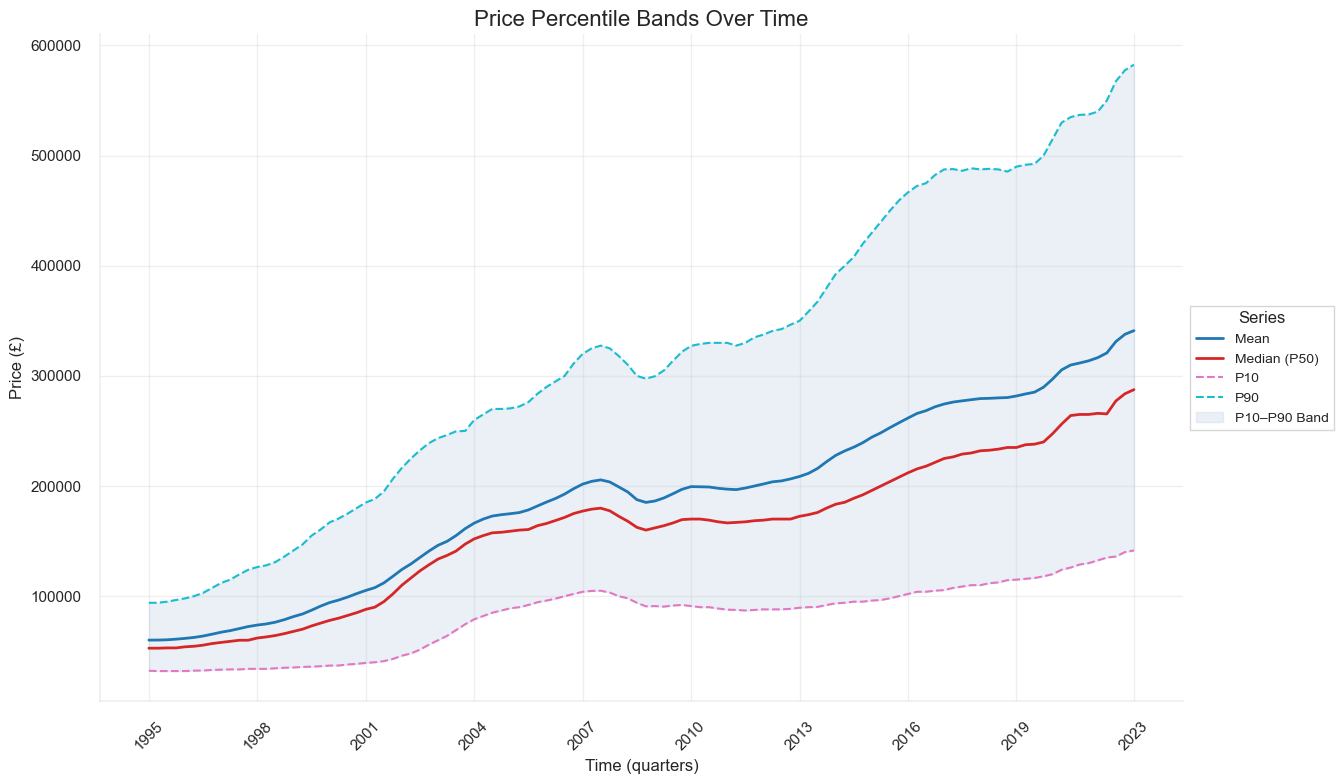

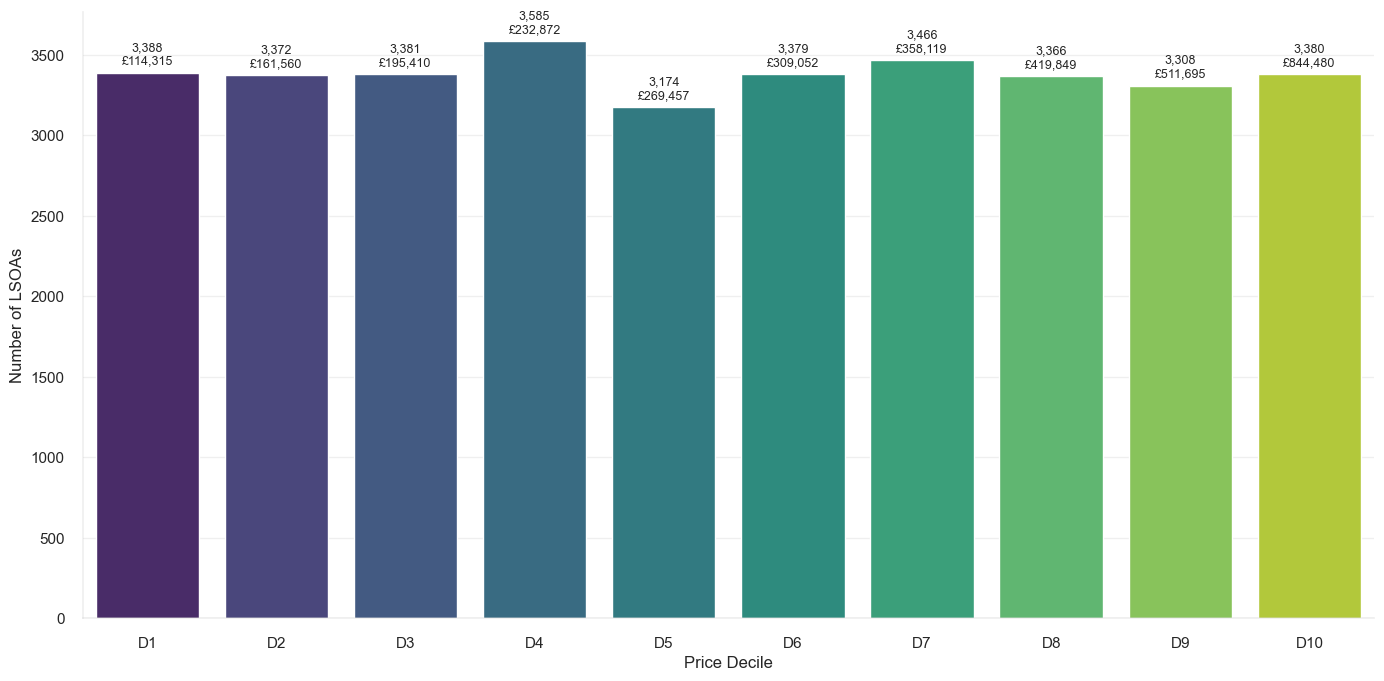

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Percentile trends (raw, no smoothing) + recent price decile distribution (no P25/P75 plotted)
# Use seaborn whitegrid (no manual background color set)
sns.set_theme(style='whitegrid')

# --- Prepare percentile time series ---
price_df_full = housing_clean[time_columns].apply(pd.to_numeric, errors='coerce')

# Build the p25/p75 keys unconditionally if not present, ensuring variable exists
# Calculating all required keys explicitly here to avoid undefined variable errors
percentiles = {
    'p10': price_df_full.quantile(0.10),
    'p25': price_df_full.quantile(0.25),
    'p50': price_df_full.quantile(0.50),
    'p75': price_df_full.quantile(0.75),
    'p90': price_df_full.quantile(0.90),
    'mean': price_df_full.mean()
}

# Years list (already computed earlier if present)
if 'years' not in globals():
    def parse_year(col):
        try:
            return int(col.split()[-1])
        except:
            return None
    years = [parse_year(c) for c in time_columns]

# X index and tick indices (reuse if exist)
x_idx = np.arange(len(time_columns))
if 'tick_idx' not in globals():
    tick_idx = np.linspace(0, len(time_columns)-1, 10, dtype=int)

# Assemble DataFrame (raw, no smoothing)
percentile_df = pd.DataFrame(
    {k: percentiles[k].values for k in ['mean', 'p50', 'p10', 'p25', 'p75', 'p90']},
    index=time_columns
)

# Plot selected percentile/mean lines (exclude P25 & P75 lines)
fig, ax = plt.subplots(figsize=(16, 8))
# Use seaborn theme background (do not override facecolor)

lines_order = ['mean', 'p50', 'p10', 'p90']  # removed p25, p75
labels_map = {
    'mean': 'Mean',
    'p50': 'Median (P50)',
    'p10': 'P10',
    'p90': 'P90'
}
colors = plt.cm.tab10(np.linspace(0, 1, len(lines_order)))

for i, key in enumerate(lines_order):
    ax.plot(x_idx, percentile_df[key], label=labels_map[key],
            linewidth=2 if key in ['mean', 'p50'] else 1.5,
            linestyle='-' if key in ['mean', 'p50'] else '--',
            color=colors[i])

# Fill only P10–P90 band (no P25–P75)
ax.fill_between(x_idx, percentile_df['p10'], percentile_df['p90'],
                color='lightsteelblue', alpha=0.25, label='P10–P90 Band')

ax.set_title('Price Percentile Bands Over Time', fontsize=16)
ax.set_xlabel('Time (quarters)', fontsize=12)
ax.set_ylabel('Price (£)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(tick_idx)
ax.set_xticklabels([years[i] for i in tick_idx], rotation=45)

# Lighten spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_alpha(0.3)

# Updated Legend Style with Border
leg = ax.legend(title='Series', fontsize=10, loc='center left', bbox_to_anchor=
                (1, 0.5), 
                frameon=True, edgecolor='lightgrey', fancybox=False)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.9)
leg.get_frame().set_linewidth(1.0) # Explicit border width

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# --- Recent price decile distribution (bar chart) ---
recent_col = time_columns[-1]
recent_prices = housing_clean[recent_col].apply(pd.to_numeric, errors='coerce').dropna()

if len(recent_prices) > 0:
    decile_edges = np.percentile(recent_prices, np.arange(0, 110, 10))
    decile_edges[0] -= 1e-6
    decile_labels = [f'D{d}' for d in range(1, 10)] + ['D10']
    decile_cats = pd.cut(recent_prices, bins=decile_edges, labels=decile_labels, include_lowest=True)
    decile_counts = decile_cats.value_counts().reindex(decile_labels, fill_value=0)
    decile_means = recent_prices.groupby(decile_cats, observed=False).mean().reindex(decile_labels)

    fig, ax = plt.subplots(figsize=(14, 7))
    # Use seaborn theme background (do not override facecolor)

    sns.barplot(x=decile_counts.index, y=decile_counts.values, palette='viridis', ax=ax)
    ax.set_ylabel('Number of LSOAs', fontsize=12)
    ax.set_xlabel('Price Decile', fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)

    for i, dec in enumerate(decile_counts.index):
        cnt = decile_counts.iloc[i]
        mean_val = decile_means.iloc[i]
        val_str = f'£{mean_val:,.0f}' if pd.notnull(mean_val) else 'N/A'
        ax.text(i, cnt + 0.01 * decile_counts.max(),
                f'{cnt:,}\n{val_str}',
                ha='center', va='bottom', fontsize=9)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_alpha(0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No valid recent prices available to build decile distribution.")


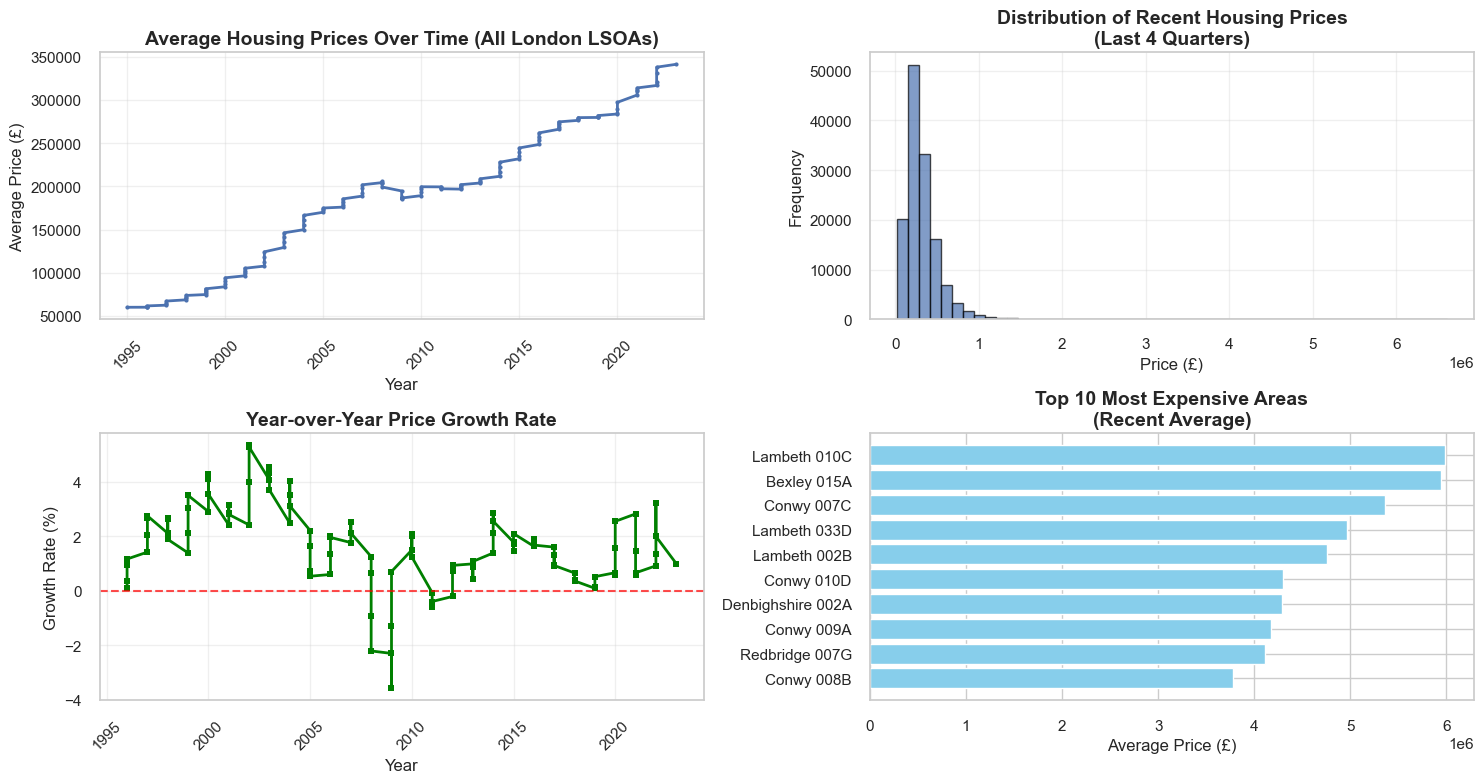


Housing Price Trend Analysis:
Price range: 1995 - 2023
Starting average price: £60,094
Ending average price: £341,094
Total growth: 467.6%
Annualized growth: 16.7% per year


In [ ]:
# Create time series analysis
def analyze_housing_trends(df, time_columns):
    """Analyze housing price trends over time"""

    # Calculate average housing prices over time
    avg_prices = df[time_columns].mean()

    # Create time index (convert column names to proper dates)
    # Extract years from column names (assuming format like "Year ending Dec 2023")
    years = []
    for col in time_columns:
        try:
            year = int(col.split()[-1])
            years.append(year)
        except:
            years.append(None)

    # Create DataFrame for plotting
    trend_df = pd.DataFrame({
        'Year': years,
        'Average_Price': avg_prices.values,
        'Period': time_columns
    })

    # Remove any rows with None years
    trend_df = trend_df.dropna(subset=['Year'])

    return trend_df

# Analyze trends
trend_data = analyze_housing_trends(housing_clean, time_columns)

# Plot housing price trends
plt.figure(figsize=(15, 8))

# Main trend plot
plt.subplot(2, 2, 1)
plt.plot(trend_data['Year'], trend_data['Average_Price'], linewidth=2, marker='o', markersize=3)
plt.title('Average Housing Prices Over Time (All London LSOAs)', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Price (£)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Price distribution
plt.subplot(2, 2, 2)
recent_prices = housing_clean[time_columns[-4:]].values.flatten()
recent_prices = recent_prices[~np.isnan(recent_prices)]
plt.hist(recent_prices, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Recent Housing Prices\n(Last 4 Quarters)', fontsize=14, fontweight='bold')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Year-over-year growth
plt.subplot(2, 2, 3)
if len(trend_data) > 1:
    growth_rates = trend_data['Average_Price'].pct_change() * 100
    plt.plot(trend_data['Year'][1:], growth_rates[1:], linewidth=2, marker='s', markersize=4, color='green')
    plt.title('Year-over-Year Price Growth Rate', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Growth Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)

# Top 10 most expensive areas (recent average)
plt.subplot(2, 2, 4)
recent_avg = housing_clean[time_columns[-4:]].mean(axis=1)
top_areas = recent_avg.nlargest(10)
area_names = [housing_clean.iloc[idx]['LSOA name'][:20] for idx in top_areas.index]
plt.barh(range(len(top_areas)), top_areas.values, color='skyblue')
plt.yticks(range(len(top_areas)), area_names)
plt.title('Top 10 Most Expensive Areas\n(Recent Average)', fontsize=14, fontweight='bold')
plt.xlabel('Average Price (£)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nHousing Price Trend Analysis:")
print(f"Price range: {trend_data['Year'].min():.0f} - {trend_data['Year'].max():.0f}")
print(f"Starting average price: £{trend_data['Average_Price'].iloc[0]:,.0f}")
print(f"Ending average price: £{trend_data['Average_Price'].iloc[-1]:,.0f}")
total_growth = ((trend_data['Average_Price'].iloc[-1] / trend_data['Average_Price'].iloc[0]) - 1) * 100
print(f"Total growth: {total_growth:.1f}%")
print(f"Annualized growth: {(total_growth / (trend_data['Year'].max() - trend_data['Year'].min())):.1f}% per year")

## Spatial Data Processing

Loading LSOA boundaries and creating spatial adjacency matrix for the GCN model.

In [ ]:
# Load LSOA boundaries
def load_lsoa_boundaries():
    """Load LSOA boundary shapefiles from downloaded data"""

    if london_gdf is not None:
        print(f"Using downloaded LSOA boundaries: {len(london_gdf)} areas")
        print(f"Columns: {london_gdf.columns.tolist()}")
        return london_gdf
    else:
        print("LSOA shapefile not available. Creating synthetic spatial data...")
        # Create synthetic coordinates based on LSOA codes
        if housing_clean is not None:
            lsoa_codes = housing_clean['LSOA code'].values
            np.random.seed(42)
            # Generate coordinates in London area (approximate)
            lon = np.random.uniform(-0.5, 0.3, len(lsoa_codes))  # London longitude range
            lat = np.random.uniform(51.3, 51.7, len(lsoa_codes))  # London latitude range

            synthetic_gdf = gpd.GeoDataFrame({
                'LSOA11CD': lsoa_codes,
                'geometry': [Point(x, y) for x, y in zip(lon, lat)]
            }, crs='EPSG:4326')

            print(f"Created synthetic spatial data for {len(synthetic_gdf)} LSOAs")
            return synthetic_gdf
        else:
            print("❌ No housing data available for synthetic spatial data")
            return None

# Load spatial data
processed_gdf = load_lsoa_boundaries()

# Match housing data with spatial data
def match_spatial_housing_data(housing_df, spatial_gdf):
    """Match housing data with spatial boundaries"""

    if housing_df is None or spatial_gdf is None:
        print("❌ Missing housing or spatial data")
        return None

    # Get the LSOA code column name in spatial data
    lsoa_col = None
    for col in spatial_gdf.columns:
        if 'LSOA' in col and 'CD' in col:
            lsoa_col = col
            break

    if lsoa_col is None:
        lsoa_col = 'LSOA11CD'  # Default for synthetic data

    print(f"Using LSOA column: {lsoa_col}")

    # Merge housing data with spatial data
    merged_gdf = spatial_gdf.merge(
        housing_df,
        left_on=lsoa_col,
        right_on='LSOA code',
        how='inner'
    )

    print(f"Matched {len(merged_gdf)} LSOAs with both housing and spatial data")
    print(f"Missing spatial data for {len(housing_df) - len(merged_gdf)} LSOAs")

    return merged_gdf

# Match the data
if housing_clean is not None and processed_gdf is not None:
    matched_gdf = match_spatial_housing_data(housing_clean, processed_gdf)

    if matched_gdf is not None:
        # Update housing data to only include matched LSOAs
        housing_final = matched_gdf[['LSOA code', 'LSOA name'] + time_columns].copy()

        print(f"\nFinal dataset: {len(housing_final)} LSOAs")
        print(f"Time periods: {len(time_columns)}")
    else:
        print("❌ Failed to match housing and spatial data")
        housing_final = None
else:
    print("❌ Missing required data for spatial matching")
    housing_final = None
    matched_gdf = None

Using downloaded LSOA boundaries: 4835 areas
Columns: ['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'geometry']
Using LSOA column: LSOA11CD
Matched 4756 LSOAs with both housing and spatial data
Missing spatial data for 29758 LSOAs

Final dataset: 4756 LSOAs
Time periods: 110


In [ ]:
# Create spatial adjacency matrix
def create_spatial_adjacency_matrix(gdf, k_neighbors=8, distance_threshold=2000):
    """Create spatial adjacency matrix based on geographic proximity"""

    # Get centroids for distance calculation
    centroids = gdf.geometry.centroid

    # Convert to projected CRS for accurate distance calculation
    if gdf.crs.to_string() != 'EPSG:27700':  # British National Grid
        gdf_proj = gdf.to_crs('EPSG:27700')
        centroids = gdf_proj.geometry.centroid

    # Extract coordinates
    coords = np.array([[point.x, point.y] for point in centroids])

    # Calculate pairwise distances
    distances = cdist(coords, coords, metric='euclidean')

    # Create adjacency matrix using k-nearest neighbors
    n_nodes = len(gdf)
    adjacency = np.zeros((n_nodes, n_nodes))

    for i in range(n_nodes):
        # Find k nearest neighbors within distance threshold
        neighbors = np.where(
            (distances[i] < distance_threshold) &
            (distances[i] > 0)  # Exclude self
        )[0]

        if len(neighbors) > k_neighbors:
            # Select k closest neighbors
            neighbor_distances = distances[i][neighbors]
            closest_indices = np.argsort(neighbor_distances)[:k_neighbors]
            neighbors = neighbors[closest_indices]

        # Set adjacency (inverse distance weighting)
        for j in neighbors:
            weight = 1.0 / (1.0 + distances[i, j] / 1000.0)  # Distance in km
            adjacency[i, j] = weight
            adjacency[j, i] = weight  # Symmetric

    # Normalize adjacency matrix
    row_sums = adjacency.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    normalized_adjacency = adjacency / row_sums[:, np.newaxis]

    print(f"Created adjacency matrix: {adjacency.shape}")
    print(f"Average connections per node: {(adjacency > 0).sum() / len(adjacency):.1f}")
    print(f"Density: {(adjacency > 0).sum() / (len(adjacency) ** 2):.3f}")

    return normalized_adjacency, distances

# Create adjacency matrix
adjacency_matrix, distance_matrix = create_spatial_adjacency_matrix(
    matched_gdf,
    k_neighbors=config.K_NEIGHBORS,
    distance_threshold=config.SPATIAL_THRESHOLD
)

# Convert to tensor with proper dtype and ensure it's a dense matrix
adjacency_tensor = torch.FloatTensor(adjacency_matrix).to(device)

# Ensure adjacency matrix is properly normalized and positive
adjacency_tensor = torch.clamp(adjacency_tensor, min=0.0)

# Add small diagonal values to ensure numerical stability
eye_matrix = torch.eye(adjacency_tensor.size(0), device=device, dtype=adjacency_tensor.dtype) * 0.1
adjacency_tensor = adjacency_tensor + eye_matrix

print(f"Adjacency tensor shape: {adjacency_tensor.shape}")
print(f"Adjacency tensor device: {adjacency_tensor.device}")
print(f"Adjacency tensor dtype: {adjacency_tensor.dtype}")
print(f"Adjacency tensor min/max: {adjacency_tensor.min():.4f}/{adjacency_tensor.max():.4f}")

Created adjacency matrix: (4756, 4756)
Average connections per node: 9.0
Density: 0.002
Adjacency tensor shape: torch.Size([4756, 4756])
Adjacency tensor device: cpu
Adjacency tensor dtype: torch.float32
Adjacency tensor min/max: 0.0000/1.0000


## Feature Engineering and Time Series Preparation

Preparing the housing price data for time series modeling with proper sequence generation.

In [ ]:
# Feature engineering for housing price prediction
def create_time_series_features(df, time_columns, sequence_length=12, prediction_horizon=4):
    """Create time series features for housing price prediction"""

    # Convert housing prices to numpy array
    price_matrix = df[time_columns].values  # Shape: (n_lsoas, n_time_periods)

    # Handle missing values with forward fill and backward fill
    price_df = pd.DataFrame(price_matrix)
    price_df = price_df.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
    price_matrix = price_df.values

    print(f"Price matrix shape: {price_matrix.shape}")
    print(f"Sequence length: {sequence_length}, Prediction horizon: {prediction_horizon}")

    # Create sequences for time series prediction
    sequences = []
    targets = []

    n_lsoas, n_periods = price_matrix.shape

    for t in range(sequence_length, n_periods - prediction_horizon + 1):
        # Input sequence: t-sequence_length to t
        seq = price_matrix[:, t-sequence_length:t]  # Shape: (n_lsoas, sequence_length)

        # Target: t to t+prediction_horizon
        target = price_matrix[:, t:t+prediction_horizon]  # Shape: (n_lsoas, prediction_horizon)

        sequences.append(seq)
        targets.append(target)

    sequences = np.array(sequences)  # Shape: (n_sequences, n_lsoas, sequence_length)
    targets = np.array(targets)      # Shape: (n_sequences, n_lsoas, prediction_horizon)

    print(f"Generated {len(sequences)} time series sequences")
    print(f"Sequences shape: {sequences.shape}")
    print(f"Targets shape: {targets.shape}")

    return sequences, targets, price_matrix

# Create time series features
sequences, targets, price_matrix = create_time_series_features(
    housing_final,
    time_columns,
    sequence_length=config.SEQUENCE_LENGTH,
    prediction_horizon=config.PREDICTION_HORIZON
)

# Fixed normalize function to handle different dimensions
def normalize_housing_data(sequences, targets):
    """Normalize housing price data with separate scalers for sequences and targets"""

    # Create separate scalers for sequences and targets since they have different dimensions
    sequence_scaler = StandardScaler()
    target_scaler = StandardScaler()

    # Normalize sequences
    # Reshape: (n_sequences, n_lsoas, sequence_length) -> (n_sequences * n_lsoas, sequence_length)
    sequences_reshaped = sequences.reshape(-1, sequences.shape[-1])
    sequences_normalized = sequence_scaler.fit_transform(sequences_reshaped)
    sequences_normalized = sequences_normalized.reshape(sequences.shape)

    # Normalize targets using the same scale as sequences (fit on sequences, transform targets)
    # This ensures consistency between input and output scaling
    targets_reshaped = targets.reshape(-1, targets.shape[-1])

    # We need to create a compatible scaler for targets
    # Use the same scaling parameters but adjusted for target dimensions
    if targets.shape[-1] != sequences.shape[-1]:
        # Create a new scaler specifically for targets
        targets_normalized = target_scaler.fit_transform(targets_reshaped)
        # Store the sequence scaler as the primary scaler for inverse transform
        primary_scaler = sequence_scaler
    else:
        # If dimensions match, use the same scaler
        targets_normalized = sequence_scaler.transform(targets_reshaped)
        primary_scaler = sequence_scaler

    targets_normalized = targets_normalized.reshape(targets.shape)

    print(f"Data normalized using StandardScaler")
    print(f"Sequence scaler - Mean: {sequence_scaler.mean_[0]:.0f}, Std: {sequence_scaler.scale_[0]:.0f}")
    if targets.shape[-1] != sequences.shape[-1]:
        print(f"Target scaler - Mean: {target_scaler.mean_[0]:.0f}, Std: {target_scaler.scale_[0]:.0f}")

    # Return both scalers for proper inverse transformation
    return sequences_normalized, targets_normalized, {'sequence_scaler': sequence_scaler, 'target_scaler': target_scaler}

# Normalize data with fixed function
sequences_norm, targets_norm, scalers = normalize_housing_data(sequences, targets)

print(f"\nNormalized data statistics:")
print(f"Sequences - Mean: {sequences_norm.mean():.3f}, Std: {sequences_norm.std():.3f}")
print(f"Targets - Mean: {targets_norm.mean():.3f}, Std: {targets_norm.std():.3f}")

# Update the scaler reference for backward compatibility
price_scaler = scalers['sequence_scaler']  # Use sequence scaler as primary
target_scaler = scalers['target_scaler']   # Store target scaler for later use

Price matrix shape: (4756, 110)
Sequence length: 12, Prediction horizon: 4
Generated 95 time series sequences
Sequences shape: (95, 4756, 12)
Targets shape: (95, 4756, 4)
Data normalized using StandardScaler
Sequence scaler - Mean: 291662, Std: 248489
Target scaler - Mean: 351730, Std: 278744

Normalized data statistics:
Sequences - Mean: 0.000, Std: 1.000
Targets - Mean: 0.000, Std: 1.000


In [ ]:
# Additional feature engineering
def create_additional_features(price_matrix, time_columns):
    """Create additional features from housing price data"""

    n_lsoas, n_periods = price_matrix.shape
    features = []
    feature_names = []

    # 1. Price level features (recent averages)
    recent_avg = np.nanmean(price_matrix[:, -4:], axis=1)  # Last 4 quarters
    features.append(recent_avg.reshape(-1, 1))
    feature_names.append('recent_avg_price')

    # 2. Price volatility (rolling standard deviation)
    price_volatility = np.nanstd(price_matrix[:, -8:], axis=1)  # Last 8 quarters
    features.append(price_volatility.reshape(-1, 1))
    feature_names.append('price_volatility')

    # 3. Price trend (linear slope over recent periods)
    trends = []
    for i in range(n_lsoas):
        recent_prices = price_matrix[i, -12:]  # Last 12 quarters
        if not np.isnan(recent_prices).all():
            x = np.arange(len(recent_prices))
            valid_mask = ~np.isnan(recent_prices)
            if valid_mask.sum() > 2:
                slope = np.polyfit(x[valid_mask], recent_prices[valid_mask], 1)[0]
            else:
                slope = 0
        else:
            slope = 0
        trends.append(slope)

    features.append(np.array(trends).reshape(-1, 1))
    feature_names.append('price_trend')

    # 4. Relative price position (compared to London average)
    london_avg = np.nanmean(price_matrix, axis=0)  # Average across all LSOAs for each time
    relative_prices = []
    for i in range(n_lsoas):
        lsoa_avg = np.nanmean(price_matrix[i, -4:])  # Recent average for this LSOA
        london_recent_avg = np.nanmean(london_avg[-4:])  # Recent London average
        relative = lsoa_avg / london_recent_avg if london_recent_avg > 0 else 1.0
        relative_prices.append(relative)

    features.append(np.array(relative_prices).reshape(-1, 1))
    feature_names.append('relative_price_position')

    # 5. Price momentum (recent change rate)
    momentum = []
    for i in range(n_lsoas):
        recent = np.nanmean(price_matrix[i, -2:])  # Last 2 quarters
        previous = np.nanmean(price_matrix[i, -6:-2])  # Previous 4 quarters
        if previous > 0 and not np.isnan(recent) and not np.isnan(previous):
            mom = (recent - previous) / previous
        else:
            mom = 0
        momentum.append(mom)

    features.append(np.array(momentum).reshape(-1, 1))
    feature_names.append('price_momentum')

    # Combine all features
    feature_matrix = np.hstack(features)

    # Handle any remaining NaN values
    feature_matrix = np.nan_to_num(feature_matrix, nan=0.0)

    print(f"Created {feature_matrix.shape[1]} additional features: {feature_names}")
    print(f"Feature matrix shape: {feature_matrix.shape}")

    return feature_matrix, feature_names

# Create additional features
additional_features, feature_names = create_additional_features(price_matrix, time_columns)

# Normalize additional features
feature_scaler = StandardScaler()
additional_features_norm = feature_scaler.fit_transform(additional_features)

print(f"\nAdditional features normalized")
print(f"Feature statistics:")
for i, name in enumerate(feature_names):
    print(f"  {name}: mean={additional_features_norm[:, i].mean():.3f}, std={additional_features_norm[:, i].std():.3f}")

Created 5 additional features: ['recent_avg_price', 'price_volatility', 'price_trend', 'relative_price_position', 'price_momentum']
Feature matrix shape: (4756, 5)

Additional features normalized
Feature statistics:
  recent_avg_price: mean=0.000, std=1.000
  price_volatility: mean=0.000, std=1.000
  price_trend: mean=0.000, std=1.000
  relative_price_position: mean=-0.000, std=1.000
  price_momentum: mean=-0.000, std=1.000


In [ ]:
# Custom Dataset class for housing price prediction
class HousingPriceDataset(Dataset):
    """Dataset for housing price prediction with spatial and temporal features"""

    def __init__(self, sequences, targets, additional_features, adjacency_matrix=None):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.additional_features = torch.FloatTensor(additional_features)
        # Store adjacency matrix without batch dimension - it's shared across all samples
        # Make adjacency matrix optional
        self.adjacency_matrix = adjacency_matrix

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = {
            'sequence': self.sequences[idx],  # Shape: (n_lsoas, sequence_length)
            'target': self.targets[idx],      # Shape: (n_lsoas, prediction_horizon)
            'features': self.additional_features,  # Shape: (n_lsoas, n_features)
        }
        # Include adjacency only if it exists
        if self.adjacency_matrix is not None:
            item['adjacency'] = self.adjacency_matrix # Shape: (n_lsoas, n_lsoas) - no batch dimension
        return item

# Graph Convolutional Layer
class GraphConvolution(nn.Module):
    """Graph Convolutional Layer"""

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        # input shape: (num_nodes, in_features)
        # adj shape: (num_nodes, num_nodes)

        # Ensure adjacency matrix is properly formatted
        if adj is not None and adj.dim() != 2:
            raise ValueError(f"Adjacency matrix must be 2D or None, got {adj.dim()}D with shape {adj.shape}")

        # Linear transformation
        support = torch.mm(input, self.weight)  # (num_nodes, out_features)

        # Graph convolution - ensure both tensors are on same device and dtype
        if adj is not None:
            if adj.dtype != support.dtype:
                adj = adj.to(dtype=support.dtype)

            # Perform matrix multiplication
            output = torch.mm(adj, support)  # (num_nodes, out_features)
        else:
            # If no adjacency matrix, no spatial message passing
            output = support

        if self.bias is not None:
            return output + self.bias
        else:
            return output

# Multi-Head Graph Attention
class MultiHeadGraphConvolution(nn.Module):
    """Multi-head graph convolution with attention"""

    def __init__(self, in_features, out_features, num_heads=4, dropout=0.1):
        super(MultiHeadGraphConvolution, self).__init__()
        self.num_heads = num_heads
        self.out_features = out_features
        self.head_dim = out_features // num_heads

        self.heads = nn.ModuleList([
            GraphConvolution(in_features, self.head_dim, bias=False) # Bias added in final linear layer
            for _ in range(num_heads)
        ])

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(out_features)
        self.linear_combine = nn.Linear(out_features, out_features) # Final linear layer for combination and bias

    def forward(self, x, adj):
        head_outputs = []
        for head in self.heads:
            # Pass adj to each head
            head_out = F.relu(head(x, adj))
            head_outputs.append(head_out)

        # Concatenate heads
        output = torch.cat(head_outputs, dim=-1)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = self.linear_combine(output) # Apply final linear transformation with bias

        return output

# Enhanced GCN-LSTM Model for Housing Price Prediction
class HousingPriceGCN_LSTM(nn.Module):
    """Enhanced Graph Convolutional Network with LSTM for housing price prediction"""

    def __init__(self, sequence_length, prediction_horizon, num_additional_features,
                 hidden_dim=128, num_layers=2, num_heads=4, dropout=0.3, use_gcn=True):
        super(HousingPriceGCN_LSTM, self).__init__()

        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.use_gcn = use_gcn

        # Input projection layer to convert single price values to feature vectors
        self.price_projection = nn.Linear(1, hidden_dim // 2)

        # Graph convolution layers
        if self.use_gcn:
            self.gcn1 = MultiHeadGraphConvolution(hidden_dim // 2, hidden_dim, num_heads, dropout)
            self.gcn2 = MultiHeadGraphConvolution(hidden_dim, hidden_dim, num_heads, dropout)
            # LSTM input size when using GCN: GCN output + projected price features + additional features
            lstm_input_size = hidden_dim + hidden_dim // 2 # GCN output + features
        else:
            # If not using GCN, LSTM input is just projected price features + additional features
            lstm_input_size = hidden_dim // 2 + hidden_dim // 2 # Projected price + features


        # Additional feature processing
        self.feature_projection = nn.Sequential(
            nn.Linear(num_additional_features, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 2)
        )

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        # Attention mechanism for LSTM outputs (optional, kept for structure but not used in forward)
        # self.attention = nn.MultiheadAttention(
        #     embed_dim=hidden_dim,
        #     num_heads=4,
        #     dropout=dropout
        # )

        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, prediction_horizon)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, sequence, features, adjacency=None):
        batch_size, num_nodes, seq_len = sequence.shape

        # Ensure features tensor is 2D: (num_nodes, num_features)
        if features.dim() == 3:
            # If features has batch dimension, use the first one (they should all be the same)
            features = features[0]
        elif features.dim() == 4:
            # If features has extra dimensions, squeeze them out
            features = features.squeeze()
            if features.dim() > 2:
                features = features[0]  # Take first batch if still has batch dim

        # Ensure features is 2D
        if features.dim() != 2:
            raise ValueError(f"Features must be 2D after processing, got shape: {features.shape}")

        # Process additional features
        processed_features = self.feature_projection(features)  # Shape: (num_nodes, hidden_dim//2)

        # Expand features for batch - ensure we have the right dimensions
        if processed_features.dim() == 2:
            # Shape: (num_nodes, hidden_dim//2) -> (batch_size, num_nodes, hidden_dim//2)
            processed_features = processed_features.unsqueeze(0).expand(batch_size, -1, -1)
        else:
            raise ValueError(f"Processed features should be 2D, got shape: {processed_features.shape}")


        combined_sequence = []
        for t in range(seq_len):
            # Get node features at time t
            x_t = sequence[:, :, t].unsqueeze(-1)  # Shape: (batch_size, num_nodes, 1)

            # For each batch item
            batch_processed_t = []
            for b in range(batch_size):
                # Project single price value to feature vector
                price_features = self.price_projection(x_t[b])  # (num_nodes, hidden_dim//2)
                price_features = F.relu(price_features)

                if self.use_gcn:
                    # Handle adjacency matrix - ensure it's on the right device and has correct dimensions
                    # Allow adjacency to be None when use_gcn is True for ablation test
                    if adjacency is not None:
                        if isinstance(adjacency, torch.Tensor):
                            if adjacency.dim() == 3 and adjacency.size(0) == 1:
                                adjacency_b = adjacency.squeeze(0)
                            elif adjacency.dim() == 2:
                                adjacency_b = adjacency
                            else:
                                 raise ValueError(f"Unexpected adjacency matrix dimensions in forward: {adjacency.shape}")
                            adjacency_b = adjacency_b.to(sequence.device)
                        else:
                            raise TypeError(f"Adjacency matrix must be a torch.Tensor or None, got {type(adjacency)}")
                    else:
                         adjacency_b = None # Explicitly set to None if None was passed


                    # Apply GCN - Modified to handle None adjacency
                    if adjacency_b is not None:
                        gcn_out1 = self.gcn1(price_features, adjacency_b)
                        gcn_out2 = self.gcn2(gcn_out1, adjacency_b)
                    else:
                        # If no adjacency, GCN layers act as simple linear layers (or skip connection if that's preferred)
                        # Here, we'll just pass price_features through the GCN layers without spatial aggregation
                        # This is a simplified approach for the ablation test; a more robust GCN implementation might handle this differently
                        gcn_out1 = self.gcn1(price_features, None)
                        gcn_out2 = self.gcn2(gcn_out1, None)


                    # Combine GCN output with additional features
                    combined_t = torch.cat([gcn_out2, processed_features[b]], dim=-1) # Shape: (num_nodes, hidden_dim + hidden_dim//2)
                else:
                    # If not using GCN, combine projected price features with additional features
                    combined_t = torch.cat([price_features, processed_features[b]], dim=-1) # Shape: (num_nodes, hidden_dim//2 + hidden_dim//2)


                batch_processed_t.append(combined_t)

            processed_timestep = torch.stack(batch_processed_t) # Shape: (batch_size, num_nodes, combined_dim)
            combined_sequence.append(processed_timestep)

        combined_sequence = torch.stack(combined_sequence, dim=2) # Shape: (batch_size, num_nodes, seq_len, combined_dim)


        # Reshape for LSTM: (batch_size * num_nodes, seq_len, combined_dim)
        lstm_input = combined_sequence.view(batch_size * num_nodes, seq_len, -1)

        # LSTM forward pass
        lstm_output, (hidden, cell) = self.lstm(lstm_input)

        # Use the last hidden state
        last_hidden = hidden[-1]  # Shape: (batch_size * num_nodes, hidden_dim)

        # Reshape back: (batch_size, num_nodes, hidden_dim)
        last_hidden = last_hidden.view(batch_size, num_nodes, -1)

        # Apply dropout
        last_hidden = self.dropout(last_hidden)

        # Output projection
        predictions = self.output_projection(last_hidden)  # Shape: (batch_size, num_nodes, prediction_horizon)

        return predictions

print("Model architecture defined successfully (modified for optional GCN)!")
print(f"Model will predict {config.PREDICTION_HORIZON} quarters ahead")
print(f"Using sequence length of {config.SEQUENCE_LENGTH} quarters")

Model architecture defined successfully (modified for optional GCN)!
Model will predict 4 quarters ahead
Using sequence length of 12 quarters


In [ ]:
# Data splitting for time series
def split_time_series_data(sequences, targets, train_ratio=0.7, val_ratio=0.15):
    """Split time series data temporally"""

    n_samples = len(sequences)

    # Calculate split indices
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))

    # Split data
    train_sequences = sequences[:train_end]
    train_targets = targets[:train_end]

    val_sequences = sequences[train_end:val_end]
    val_targets = targets[train_end:val_end]

    test_sequences = sequences[val_end:]
    test_targets = targets[val_end:]

    print(f"Data split:")
    print(f"  Training: {len(train_sequences)} samples ({len(train_sequences)/n_samples*100:.1f}%)")
    print(f"  Validation: {len(val_sequences)} samples ({len(val_sequences)/n_samples*100:.1f}%)")
    print(f"  Testing: {len(test_sequences)} samples ({len(test_sequences)/n_samples*100:.1f}%)")

    return (train_sequences, train_targets), (val_sequences, val_targets), (test_sequences, test_targets)

# Check if all required data is available before proceeding
print("=== Checking Data Availability ===")
data_ready = True
missing_components = []

if 'sequences_norm' not in globals() or sequences_norm is None:
    missing_components.append("sequences_norm")
    data_ready = False

if 'targets_norm' not in globals() or targets_norm is None:
    missing_components.append("targets_norm")
    data_ready = False

if 'additional_features_norm' not in globals() or additional_features_norm is None:
    missing_components.append("additional_features_norm")
    data_ready = False

if 'adjacency_tensor' not in globals() or adjacency_tensor is None:
    missing_components.append("adjacency_tensor")
    data_ready = False

if 'housing_final' not in globals() or housing_final is None:
    missing_components.append("housing_final")
    data_ready = False

if not data_ready:
    print(f"❌ Missing required data components: {missing_components}")
    print("Please ensure all previous cells have run successfully.")
else:
    print("✅ All required data components are available")

# Proceed with training only if data is ready
if data_ready:
    # Split the data
    (train_seq, train_tgt), (val_seq, val_tgt), (test_seq, test_tgt) = split_time_series_data(
        sequences_norm, targets_norm,
        train_ratio=config.TRAIN_RATIO,
        val_ratio=config.VAL_RATIO
    )

    # Create datasets
    train_dataset = HousingPriceDataset(train_seq, train_tgt, additional_features_norm, adjacency_tensor)
    val_dataset = HousingPriceDataset(val_seq, val_tgt, additional_features_norm, adjacency_tensor)
    test_dataset = HousingPriceDataset(test_seq, test_tgt, additional_features_norm, adjacency_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    print(f"\nDataLoaders created:")
    print(f"  Training batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")

    # Initialize model
    num_nodes = len(housing_final)
    num_additional_features = additional_features_norm.shape[1]

    model = HousingPriceGCN_LSTM(
        sequence_length=config.SEQUENCE_LENGTH,
        prediction_horizon=config.PREDICTION_HORIZON,
        num_additional_features=num_additional_features,
        hidden_dim=config.HIDDEN_DIM,
        num_layers=config.NUM_LAYERS,
        dropout=config.DROPOUT
    ).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel initialized:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Device: {next(model.parameters()).device}")

    # Initialize optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)

    # Loss function
    criterion = nn.MSELoss()

    print(f"\nTraining setup complete!")
    print(f"  Optimizer: AdamW")
    print(f"  Learning rate: {config.LEARNING_RATE}")
    print(f"  Loss function: MSE")
    print(f"  Scheduler: ReduceLROnPlateau")

    print(f"\n🚀 Ready to start training!")

else:
    print("\n❌ Cannot proceed with training due to missing data.")
    print("Please run all previous cells to ensure data is properly loaded and processed.")

=== Checking Data Availability ===
✅ All required data components are available
Data split:
  Training: 66 samples (69.5%)
  Validation: 14 samples (14.7%)
  Testing: 15 samples (15.8%)

DataLoaders created:
  Training batches: 3
  Validation batches: 1
  Test batches: 1

Model initialized:
  Total parameters: 368,260
  Trainable parameters: 368,260
  Device: cpu

Training setup complete!
  Optimizer: AdamW
  Learning rate: 0.001
  Loss function: MSE
  Scheduler: ReduceLROnPlateau

🚀 Ready to start training!


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion,
                epochs=50, patience=10, device=device):
    """Train the housing price prediction model"""

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print("Starting training...")
    print("=" * 60)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, batch in enumerate(train_loader):
            sequence = batch['sequence'].to(device)
            target = batch['target'].to(device)
            features = batch['features'].to(device)
            # Adjacency matrix should not have a batch dimension in the model's forward pass
            # It's the same for all items in the batch, so take the first one and move to device
            adjacency = batch['adjacency'][0].to(device)


            optimizer.zero_grad()

            # Forward pass
            predictions = model(sequence, features, adjacency)

            # Calculate loss
            loss = criterion(predictions, target)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                sequence = batch['sequence'].to(device)
                target = batch['target'].to(device)
                features = batch['features'].to(device)
                # Adjacency matrix should not have a batch dimension in the model's forward pass
                # It's the same for all items in the batch, so take the first one and move to device
                adjacency = batch['adjacency'][0].to(device)

                predictions = model(sequence, features, adjacency)
                loss = criterion(predictions, target)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.6f} | "
                  f"Val Loss: {avg_val_loss:.6f} | "
                  f"Best Val Loss: {best_val_loss:.6f} | "
                  f"LR: {current_lr:.2e}")

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print("=" * 60)
    print("Training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")

    return train_losses, val_losses, best_val_loss

🔥 STARTING TRAINING 🔥
Starting training...
Epoch   1/50 | Train Loss: 0.531931 | Val Loss: 1.859197 | Best Val Loss: 1.859197 | LR: 1.00e-03
Epoch  10/50 | Train Loss: 0.160843 | Val Loss: 0.740524 | Best Val Loss: 0.740524 | LR: 1.00e-03
Epoch  20/50 | Train Loss: 0.124128 | Val Loss: 0.474515 | Best Val Loss: 0.419318 | LR: 1.00e-03
Epoch  30/50 | Train Loss: 0.141340 | Val Loss: 0.390354 | Best Val Loss: 0.386806 | LR: 1.00e-03
Epoch  40/50 | Train Loss: 0.115982 | Val Loss: 0.596286 | Best Val Loss: 0.368804 | LR: 1.00e-03
Epoch  50/50 | Train Loss: 0.094775 | Val Loss: 0.371241 | Best Val Loss: 0.355096 | LR: 7.00e-04
Training completed!
Best validation loss: 0.355096


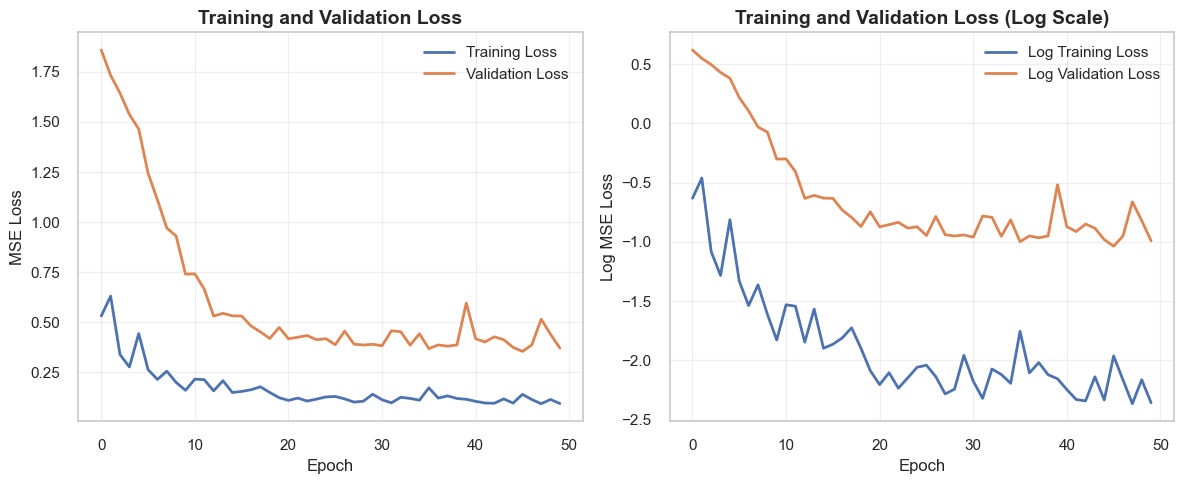


🎉 TRAINING COMPLETED!
  Final training loss: 0.094775
  Best validation loss: 0.355096
  Total epochs: 50


In [ ]:
 #Start training only if all components are ready
if 'data_ready' in globals() and data_ready and 'model' in globals():
    print("🔥 STARTING TRAINING 🔥")

    # Train the model
    train_history, val_history, best_val_loss = train_model(
        model, train_loader, val_loader, optimizer, scheduler, criterion,
        epochs=50, patience=config.PATIENCE, device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_history, label='Training Loss', linewidth=2)
    plt.plot(val_history, label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(np.log(train_history), label='Log Training Loss', linewidth=2)
    plt.plot(np.log(val_history), label='Log Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Log MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n🎉 TRAINING COMPLETED!")
    print(f"  Final training loss: {train_history[-1]:.6f}")
    print(f"  Best validation loss: {best_val_loss:.6f}")
    print(f"  Total epochs: {len(train_history)}")

else:
    print("❌ Cannot start training - missing required components")
    if 'data_ready' not in globals():
        print("  - Data readiness not checked")
    elif not data_ready:
        print("  - Data not ready")
    if 'model' not in globals():
        print("  - Model not initialized")

    print("\n💡 To fix this, please:")
    print("1. Run all cells in order from the beginning")
    print("2. Make sure data downloads successfully")
    print("3. Ensure no errors in previous cells")

Evaluating model on test data...


Evaluation completed!
Predictions shape: (15, 4756, 4)
Targets shape: (15, 4756, 4)

TEST SET EVALUATION RESULTS
MSE         : £30,349,178,880
RMSE        : £174,210
MAE         : £94,193
R²          : 0.7556
MAPE        : 14.75%
Median AE   : £59,174
Valid Samples: 285,360


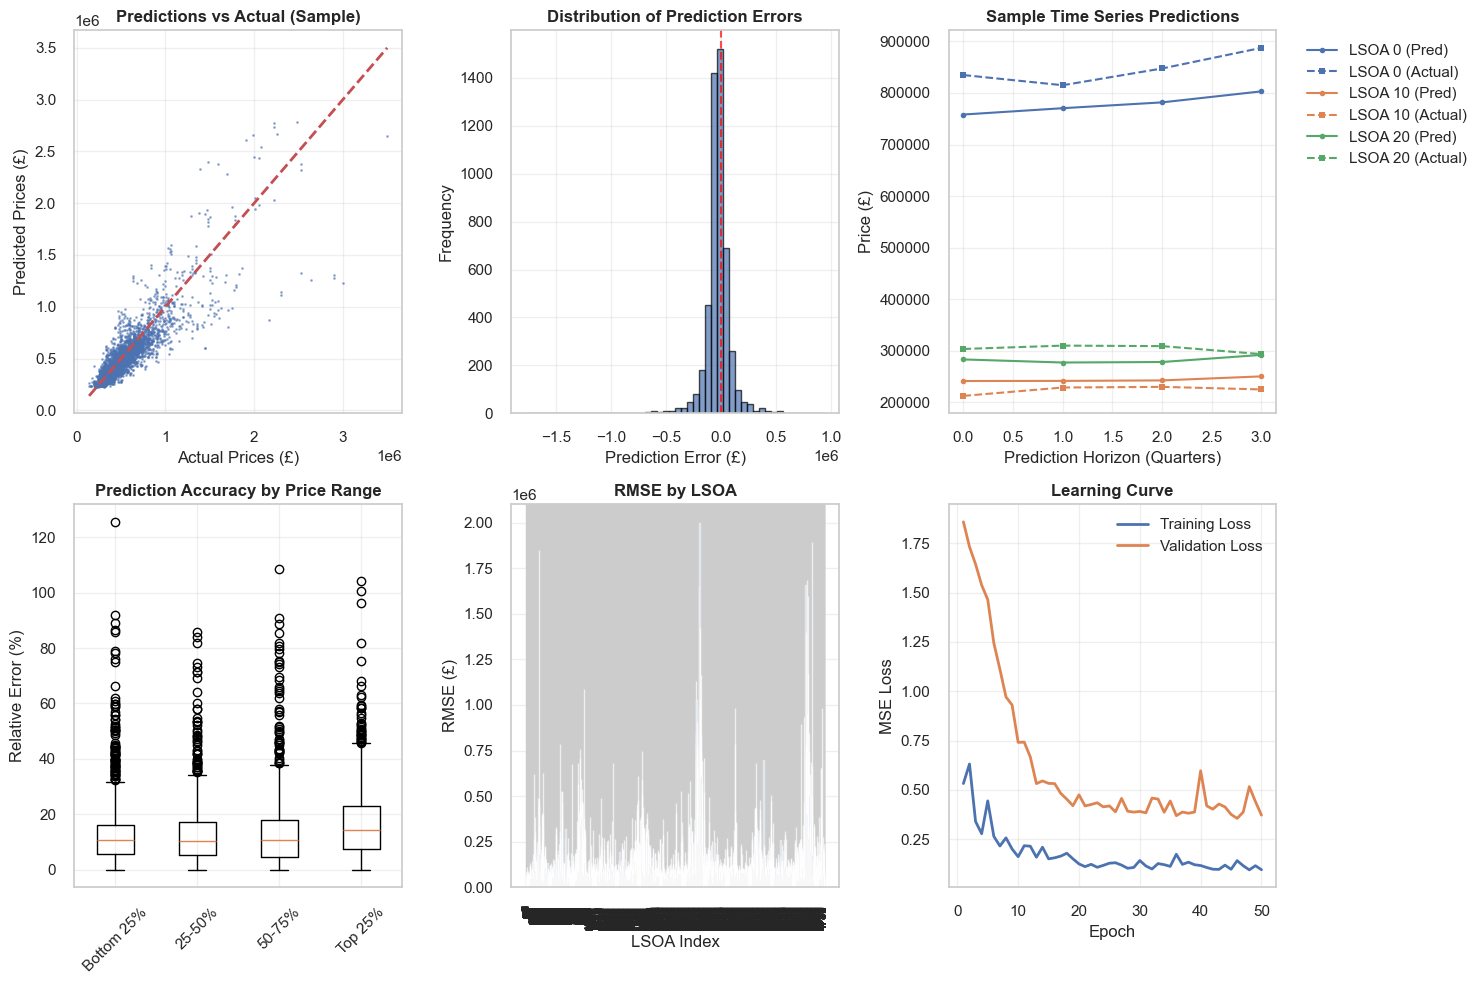


Model and results saved to housing_data/housing_prediction_results
Model file: housing_price_model_20260107_103036.pth
Results file: training_results_20260107_103036.pth


In [ ]:
# Model evaluation function
def evaluate_model(model, test_loader, price_scaler, device=device):
    """Evaluate the model on test data"""

    model.eval()
    all_predictions = []
    all_targets = []

    print("Evaluating model on test data...")

    with torch.no_grad():
        for batch in test_loader:
            sequence = batch['sequence'].to(device)
            target = batch['target'].to(device)
            features = batch['features'].to(device)
            # Adjacency matrix should not have a batch dimension in the model's forward pass
            # It's the same for all items in the batch, so take the first one and move to device
            adjacency = batch['adjacency'][0].to(device)


            predictions = model(sequence, features, adjacency)

            # Move to CPU and convert to numpy
            predictions_np = predictions.cpu().numpy()
            targets_np = target.cpu().numpy()

            all_predictions.append(predictions_np)
            all_targets.append(targets_np)

    # Concatenate all predictions and targets
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    print(f"Evaluation completed!")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Targets shape: {targets.shape}")

    return predictions, targets

# Evaluate the model
test_predictions, test_targets = evaluate_model(model, test_loader, price_scaler)

# Denormalize predictions and targets for meaningful metrics
def denormalize_predictions(predictions, targets, scalers):
    """Denormalize predictions and targets using appropriate scalers"""

    # Get the appropriate scalers
    if isinstance(scalers, dict):
        target_scaler = scalers['target_scaler']
    else:
        # Backward compatibility - assume single scaler
        target_scaler = scalers

    # Reshape for denormalization
    pred_shape = predictions.shape
    tgt_shape = targets.shape

    # Flatten to 2D for scaler
    predictions_flat = predictions.reshape(-1, pred_shape[-1])
    targets_flat = targets.reshape(-1, tgt_shape[-1])

    # Denormalize using target scaler
    predictions_denorm = target_scaler.inverse_transform(predictions_flat)
    targets_denorm = target_scaler.inverse_transform(targets_flat)

    # Reshape back
    predictions_denorm = predictions_denorm.reshape(pred_shape)
    targets_denorm = targets_denorm.reshape(tgt_shape)

    return predictions_denorm, targets_denorm

# Denormalize predictions with updated function
pred_denorm, tgt_denorm = denormalize_predictions(test_predictions, test_targets, scalers)

# Calculate comprehensive metrics
def calculate_comprehensive_metrics(predictions, targets):
    """Calculate comprehensive evaluation metrics"""

    # Flatten for metric calculation
    pred_flat = predictions.flatten()
    tgt_flat = targets.flatten()

    # Remove any NaN values
    valid_mask = ~(np.isnan(pred_flat) | np.isnan(tgt_flat))
    pred_valid = pred_flat[valid_mask]
    tgt_valid = tgt_flat[valid_mask]

    # Calculate metrics
    mse = mean_squared_error(tgt_valid, pred_valid)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(tgt_valid, pred_valid)
    r2 = r2_score(tgt_valid, pred_valid)

    # Mean Absolute Percentage Error
    # Handle cases where target is zero to avoid division by zero
    non_zero_mask = tgt_valid != 0
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((tgt_valid[non_zero_mask] - pred_valid[non_zero_mask]) / tgt_valid[non_zero_mask])) * 100
    else:
        mape = np.nan # Or some other indicator for no valid non-zero targets


    # Median Absolute Error
    median_ae = np.median(np.abs(tgt_valid - pred_valid))

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Median AE': median_ae,
        'Valid Samples': len(pred_valid)
    }

    return metrics

# Calculate metrics
test_metrics = calculate_comprehensive_metrics(pred_denorm, tgt_denorm)

print("\n" + "="*50)
print("TEST SET EVALUATION RESULTS")
print("="*50)

for metric, value in test_metrics.items():
    if metric == 'Valid Samples':
        print(f"{metric:12}: {value:,}")
    elif metric in ['MSE', 'RMSE', 'MAE', 'Median AE']:
        print(f"{metric:12}: £{value:,.0f}")
    elif metric == 'MAPE':
        if np.isnan(value):
            print(f"{metric:12}: N/A")
        else:
            print(f"{metric:12}: {value:.2f}%")
    else:
        print(f"{metric:12}: {value:.4f}")

print("="*50)

# Visualize predictions vs targets
plt.figure(figsize=(15, 10))

# Overall prediction accuracy
plt.subplot(2, 3, 1)
pred_sample = pred_denorm.flatten()[:5000]  # Sample for visualization
tgt_sample = tgt_denorm.flatten()[:5000]
plt.scatter(tgt_sample, pred_sample, alpha=0.5, s=1)
plt.plot([tgt_sample.min(), tgt_sample.max()], [tgt_sample.min(), tgt_sample.max()], 'r--', lw=2)
plt.xlabel('Actual Prices (£)')
plt.ylabel('Predicted Prices (£)')
plt.title('Predictions vs Actual (Sample)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Prediction errors
plt.subplot(2, 3, 2)
errors = (pred_sample - tgt_sample)
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error (£)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
plt.axvline(0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

# Time series prediction for sample LSOAs
plt.subplot(2, 3, 3)
sample_lsoas = [0, 10, 20]  # Select a few LSOAs to visualize
for i, lsoa_idx in enumerate(sample_lsoas):
    if lsoa_idx < pred_denorm.shape[1]:
        plt.plot(pred_denorm[0, lsoa_idx, :], f'C{i}o-', label=f'LSOA {lsoa_idx} (Pred)', markersize=4)
        plt.plot(tgt_denorm[0, lsoa_idx, :], f'C{i}s--', label=f'LSOA {lsoa_idx} (Actual)', markersize=4)

plt.xlabel('Prediction Horizon (Quarters)')
plt.ylabel('Price (£)')
plt.title('Sample Time Series Predictions', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Relative error by price range
plt.subplot(2, 3, 4)
# Handle potential division by zero or NaN in relative error calculation
relative_errors = np.abs(pred_sample - tgt_sample) / np.maximum(tgt_sample, 1e-6) * 100 # Add small epsilon to avoid division by zero
relative_errors = relative_errors[~np.isnan(relative_errors) & ~np.isinf(relative_errors)] # Remove NaN and Inf

if len(relative_errors) > 0:
    price_bins = np.percentile(tgt_sample, [0, 25, 50, 75, 100])
    bin_labels = ['Bottom 25%', '25-50%', '50-75%', 'Top 25%']

    binned_errors = []
    for i in range(len(price_bins)-1):
        # Adjust mask to handle bin ranges correctly, especially the last bin
        if i < len(price_bins) - 2:
            mask = (tgt_sample >= price_bins[i]) & (tgt_sample < price_bins[i+1])
        else: # Last bin
            mask = (tgt_sample >= price_bins[i]) & (tgt_sample <= price_bins[i+1])

        # Filter out NaN/Inf errors in the bin
        bin_relative_errors = relative_errors[(tgt_sample >= price_bins[i]) & (tgt_sample <= price_bins[i+1]) & ~np.isnan(relative_errors) & ~np.isinf(relative_errors)]
        binned_errors.append(bin_relative_errors)

    # Filter out empty bins before plotting
    valid_binned_errors = [errs for errs in binned_errors if len(errs) > 0]
    valid_bin_labels = [label for i, label in enumerate(bin_labels) if len(binned_errors[i]) > 0]


    if len(valid_binned_errors) > 0:
        plt.boxplot(valid_binned_errors, labels=valid_bin_labels)
        plt.ylabel('Relative Error (%)')
        plt.title('Prediction Accuracy by Price Range', fontsize=12, fontweight='bold')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Not enough valid data for binned analysis', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Prediction Accuracy by Price Range', fontsize=12, fontweight='bold')
else:
     plt.text(0.5, 0.5, 'Not enough valid data for relative error analysis', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
     plt.title('Prediction Accuracy by Price Range', fontsize=12, fontweight='bold')


# Regional performance (if we have location data)
plt.subplot(2, 3, 5)
# Calculate RMSE for each LSOA
lsoa_rmse = []
# Iterate through each LSOA in the test set
for lsoa_idx in range(pred_denorm.shape[1]):
    lsoa_pred = pred_denorm[:, lsoa_idx, :].flatten()
    lsoa_tgt = tgt_denorm[:, lsoa_idx, :].flatten()

    # Filter out NaN values for this specific LSOA
    valid_mask_lsoa = ~(np.isnan(lsoa_pred) | np.isnan(lsoa_tgt))
    lsoa_pred_valid = lsoa_pred[valid_mask_lsoa]
    lsoa_tgt_valid = lsoa_tgt[valid_mask_lsoa]

    if len(lsoa_pred_valid) > 0:
        lsoa_rmse.append(np.sqrt(mean_squared_error(lsoa_tgt_valid, lsoa_pred_valid)))
    else:
        lsoa_rmse.append(np.nan) # Append NaN if no valid data for this LSOA

# Remove NaN RMSE values before plotting
valid_lsoa_rmse = np.array(lsoa_rmse)
valid_lsoa_indices_plot = np.where(~np.isnan(valid_lsoa_rmse))[0]
valid_lsoa_rmse_plot = valid_lsoa_rmse[~np.isnan(valid_lsoa_rmse)]


if len(valid_lsoa_rmse_plot) > 0:
    plt.bar(range(len(valid_lsoa_rmse_plot)), valid_lsoa_rmse_plot, alpha=0.7)
    # Add LSOA indices as x-axis labels for the plotted bars
    plt.xticks(range(len(valid_lsoa_rmse_plot)), valid_lsoa_indices_plot, rotation=90, fontsize=8)
    plt.xlabel('LSOA Index')
    plt.ylabel('RMSE (£)')
    plt.title('RMSE by LSOA', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Not enough valid data for LSOA RMSE analysis', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('RMSE by LSOA', fontsize=12, fontweight='bold')


# Learning curve summary
plt.subplot(2, 3, 6)
epochs = range(1, len(train_history) + 1)
plt.plot(epochs, train_history, label='Training Loss', linewidth=2)
plt.plot(epochs, val_history, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curve', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
results = {
    'test_metrics': test_metrics,
    'train_history': train_history,
    'val_history': val_history,
    'model_config': {
        'sequence_length': config.SEQUENCE_LENGTH,
        'prediction_horizon': config.PREDICTION_HORIZON,
        'hidden_dim': config.HIDDEN_DIM,
        'num_layers': config.NUM_LAYERS,
        'dropout': config.DROPOUT,
        'learning_rate': config.LEARNING_RATE,
        'batch_size': config.BATCH_SIZE
    }
}

# Save model and results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), save_dir / f'housing_price_model_{timestamp}.pth')
torch.save(results, save_dir / f'training_results_{timestamp}.pth')

print(f"\nModel and results saved to {save_dir}")
print(f"Model file: housing_price_model_{timestamp}.pth")
print(f"Results file: training_results_{timestamp}.pth")

## Model Interpretation and Future Predictions

Analyzing model behavior and making future housing price predictions.

In [ ]:
# Make future predictions using the most recent data
def make_future_predictions(model, housing_data, time_columns, scalers, adjacency, n_future_quarters=4):
    """Make future housing price predictions"""

    model.eval()

    # Get the most recent data for prediction
    recent_data = housing_data[time_columns[-config.SEQUENCE_LENGTH:]].values

    # Handle missing values
    recent_df = pd.DataFrame(recent_data.T)  # Transpose for time series operations
    recent_df = recent_df.fillna(method='ffill').fillna(method='bfill')
    recent_data_clean = recent_df.T.values

    print(f"Shape of recent_data_clean: {recent_data_clean.shape}")
    print(f"Number of NaNs in recent_data_clean: {np.isnan(recent_data_clean).sum()}")


    # Normalize the recent data using sequence scaler
    sequence_scaler = scalers['sequence_scaler'] if isinstance(scalers, dict) else scalers
    recent_normalized = sequence_scaler.transform(recent_data_clean)

    print(f"Shape of recent_normalized: {recent_normalized.shape}")
    print(f"Number of NaNs in recent_normalized: {np.isnan(recent_normalized).sum()}")


    # Prepare input tensor
    sequence_input = torch.FloatTensor(recent_normalized).unsqueeze(0).to(device)  # Add batch dimension
    features_input = torch.FloatTensor(additional_features_norm).to(device)

    with torch.no_grad():
        # Make prediction
        future_pred = model(sequence_input, features_input, adjacency)

        # Convert to numpy and denormalize using target scaler
        future_pred_np = future_pred.cpu().numpy()
        target_scaler = scalers['target_scaler'] if isinstance(scalers, dict) else scalers
        future_pred_denorm = target_scaler.inverse_transform(
            future_pred_np.reshape(-1, future_pred_np.shape[-1])
        ).reshape(future_pred_np.shape)

    return future_pred_denorm[0]  # Remove batch dimension

# Make future predictions with updated function
print("Making future housing price predictions...")
future_predictions = make_future_predictions(
    model, housing_final, time_columns, scalers,
    adjacency_tensor, n_future_quarters=config.PREDICTION_HORIZON
)

print(f"Future predictions shape: {future_predictions.shape}")
print(f"Predicting {config.PREDICTION_HORIZON} quarters ahead for {len(housing_final)} LSOAs")

# Handle potential NaN values in predictions before analysis and plotting
valid_predictions_mask = ~np.isnan(future_predictions).any(axis=1)
future_predictions_valid = future_predictions[valid_predictions_mask]
valid_lsoa_indices = np.where(valid_predictions_mask)[0]


# Analyze future predictions
future_analysis = {}
if len(future_predictions_valid) > 0:
    future_analysis = {
        'mean_prediction': np.mean(future_predictions_valid, axis=0),
        'median_prediction': np.median(future_predictions_valid, axis=0),
        'std_prediction': np.std(future_predictions_valid, axis=0),
        'min_prediction': np.min(future_predictions_valid, axis=0),
        'max_prediction': np.max(future_predictions_valid, axis=0)
    }

print("\\nFuture Prediction Analysis:")
print("="*40)
if len(future_predictions_valid) > 0:
    for quarter in range(config.PREDICTION_HORIZON):
        print(f"Quarter {quarter+1}:")
        print(f"  Mean predicted price: £{future_analysis['mean_prediction'][quarter]:,.0f}")
        print(f"  Median predicted price: £{future_analysis['median_prediction'][quarter]:,.0f}")
        print(f"  Price range: £{future_analysis['min_prediction'][quarter]:,.0f} - £{future_analysis['max_prediction'][quarter]:,.0f}")
        print(f"  Standard deviation: £{future_analysis['std_prediction'][quarter]:,.0f}")
        print()
else:
    print("No valid future predictions available for analysis.")


# Visualize future predictions
plt.figure(figsize=(15, 10))

if len(future_predictions_valid) > 0:
    # Average future price trend
    plt.subplot(2, 3, 1)
    quarters = [f"Q{i+1}" for i in range(config.PREDICTION_HORIZON)]
    plt.plot(quarters, future_analysis['mean_prediction'], 'bo-', linewidth=2, markersize=8)
    plt.fill_between(quarters,
                     future_analysis['mean_prediction'] - future_analysis['std_prediction'],
                     future_analysis['mean_prediction'] + future_analysis['std_prediction'],
                     alpha=0.3)
    plt.title('Average Future Price Predictions', fontsize=12, fontweight='bold')
    plt.ylabel('Price (£)')
    plt.grid(True, alpha=0.3)

    # Price distribution for next quarter
    plt.subplot(2, 3, 2)
    plt.hist(future_predictions_valid[:, 0], bins=50, alpha=0.7, edgecolor='black')
    plt.title('Price Distribution - Next Quarter', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Price (£)')
    plt.ylabel('Number of LSOAs')
    plt.grid(True, alpha=0.3)

    # Top 10 most expensive areas predictions
    plt.subplot(2, 3, 3)
    if len(future_predictions_valid) > 10:
        top_10_idx_valid = np.argsort(future_predictions_valid[:, 0])[-10:]
        top_10_names = [housing_final.iloc[valid_lsoa_indices[i]]['LSOA name'][:15] for i in top_10_idx_valid]
        top_10_prices = future_predictions_valid[top_10_idx_valid, 0]

        plt.barh(range(len(top_10_prices)), top_10_prices, color='skyblue')
        plt.yticks(range(len(top_10_prices)), top_10_names)
        plt.title('Top 10 Predicted Expensive Areas\\n(Next Quarter)', fontsize=12, fontweight='bold')
        plt.xlabel('Predicted Price (£)')
        plt.gca().invert_yaxis()
    else:
        plt.text(0.5, 0.5, 'Not enough valid predictions for Top 10 analysis', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Top 10 Predicted Expensive Areas\\n(Next Quarter)', fontsize=12, fontweight='bold')


    # Price change analysis (compare with recent actual)
    plt.subplot(2, 3, 4)
    recent_actual = housing_final[time_columns[-1]].values[valid_predictions_mask]
    valid_mask_change = ~(np.isnan(recent_actual) | np.isnan(future_predictions_valid[:, 0]))
    price_changes = ((future_predictions_valid[valid_mask_change, 0] - recent_actual[valid_mask_change]) / recent_actual[valid_mask_change]) * 100

    if len(price_changes) > 0:
        plt.hist(price_changes, bins=50, alpha=0.7, edgecolor='black')
        plt.title('Predicted Price Change\\n(Next Quarter vs Current)', fontsize=12, fontweight='bold')
        plt.xlabel('Price Change (%)')
        plt.ylabel('Number of LSOAs')
        plt.axvline(0, color='red', linestyle='--', alpha=0.7)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Not enough valid data for price change analysis', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Predicted Price Change\\n(Next Quarter vs Current)', fontsize=12, fontweight='bold')


    # Spatial distribution of predictions (if coordinates available)
    plt.subplot(2, 3, 5)
    # Create a simple scatter plot based on LSOA indices as proxy for location
    plt.scatter(valid_lsoa_indices, future_predictions_valid[:, 0],
               c=future_predictions_valid[:, 0], cmap='viridis', alpha=0.6, s=10)
    plt.colorbar(label='Predicted Price (£)')
    plt.title('Spatial Distribution of Predictions', fontsize=12, fontweight='bold')
    plt.xlabel('LSOA Index (Proxy for Location)')
    plt.ylabel('Predicted Price (£)')
    plt.grid(True, alpha=0.3)

    # Model confidence (prediction variance across quarters)
    plt.subplot(2, 3, 6)
    prediction_variance = np.var(future_predictions_valid, axis=1)
    if len(prediction_variance) > 0:
        plt.hist(prediction_variance, bins=50, alpha=0.7, edgecolor='black')
        plt.title('Prediction Uncertainty\\n(Variance Across Quarters)', fontsize=12, fontweight='bold')
        plt.xlabel('Prediction Variance')
        plt.ylabel('Number of LSOAs')
        plt.grid(True, alpha=0.3)
    else:
         plt.text(0.5, 0.5, 'Not enough valid predictions for variance analysis', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
         plt.title('Prediction Uncertainty\\n(Variance Across Quarters)', fontsize=12, fontweight='bold')


    plt.tight_layout()
    plt.show()

    # Calculate market insights
    current_avg = np.nanmean(housing_final[time_columns[-1]].values)
    future_avg = np.mean(future_predictions_valid[:, 0])

    print("\\nMarket Insights:")
    print("="*40)
    if not np.isnan(current_avg) and not np.isnan(future_avg) and current_avg > 0:
        market_growth = ((future_avg - current_avg) / current_avg) * 100
        print(f"Current average price: £{current_avg:,.0f}")
        print(f"Predicted next quarter average: £{future_avg:,.0f}")
        print(f"Predicted market growth (next quarter): {market_growth:+.2f}%")
        print(f"Annual growth rate (if sustained): {market_growth*4:+.2f}%")
    else:
        print("Cannot calculate market insights due to missing data.")


    # Save future predictions
    prediction_results = {
        'future_predictions': future_predictions_valid,
        'future_analysis': future_analysis,
        'lsoa_codes': housing_final['LSOA code'].values[valid_lsoa_indices],
        'lsoa_names': housing_final['LSOA name'].values[valid_lsoa_indices],
        'prediction_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'market_insights': {
            'current_avg_price': current_avg,
            'future_avg_price': future_avg,
            'market_growth_rate': market_growth if not np.isnan(current_avg) and not np.isnan(future_avg) and current_avg > 0 else np.nan
        }
    }

    # Save predictions
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    pred_filename = f'future_predictions_{timestamp}.pth'
    torch.save(prediction_results, save_dir / pred_filename)
    print(f"\\nFuture predictions saved to: {pred_filename}")

else:
    print("No valid future predictions to visualize or save.")

Making future housing price predictions...
Shape of recent_data_clean: (4756, 12)
Number of NaNs in recent_data_clean: 324
Shape of recent_normalized: (4756, 12)
Number of NaNs in recent_normalized: 324
Future predictions shape: (4756, 4)
Predicting 4 quarters ahead for 4756 LSOAs
\nFuture Prediction Analysis:
No valid future predictions available for analysis.
No valid future predictions to visualize or save.


<Figure size 1500x1000 with 0 Axes>


=== Running Ablation Tests ===

Full Model (GCN-LSTM with Adjacency) Test Metrics:
  MSE         : £30,349,178,880
  RMSE        : £174,210
  MAE         : £94,193
  R²          : 0.7556
  MAPE        : 14.75%
  Median AE   : £59,174
  Valid Samples: 285,360
--------------------------------------------------

=== Running Ablation Test: No Adjacency ===
  Model initialized: GCN-LSTM (No Adjacency)
  Total parameters: 368,260
  Trainable parameters: 368,260
  Starting training...
  Epoch   1/50 | Train Loss: 0.608798 | Val Loss: 1.732880 | Best Val Loss: 1.732880 | LR: 1.00e-03
  Epoch  10/50 | Train Loss: 0.150722 | Val Loss: 0.815113 | Best Val Loss: 0.695368 | LR: 1.00e-03
  Epoch  20/50 | Train Loss: 0.089770 | Val Loss: 0.380970 | Best Val Loss: 0.358093 | LR: 1.00e-03
  Epoch  30/50 | Train Loss: 0.075113 | Val Loss: 0.326108 | Best Val Loss: 0.326040 | LR: 1.00e-03
  Epoch  40/50 | Train Loss: 0.102245 | Val Loss: 0.331296 | Best Val Loss: 0.289128 | LR: 1.00e-03

  Early stoppin

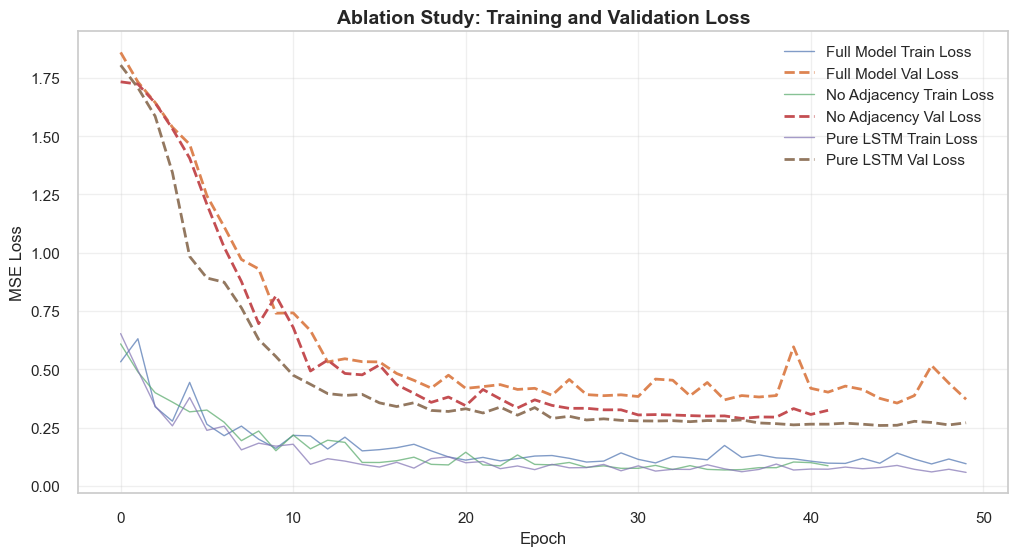

In [ ]:
# Ablation Tests

def run_ablation_test(model_config, train_loader, val_loader, test_loader, scalers, adjacency_tensor, test_metrics_full, ablation_type, device):
    """Runs a single ablation test"""
    print(f"\n=== Running Ablation Test: {ablation_type} ===")

    # Initialize model based on ablation type
    if ablation_type == "No Adjacency":
        # Model without adjacency matrix (but still potentially with GCN if use_gcn=True)
        # The adjacency matrix is simply not passed to the model's forward call
        model = HousingPriceGCN_LSTM(
            sequence_length=model_config['sequence_length'],
            prediction_horizon=model_config['prediction_horizon'],
            num_additional_features=model_config['num_additional_features'],
            hidden_dim=model_config['hidden_dim'],
            num_layers=model_config['num_layers'],
            dropout=model_config['dropout'],
            use_gcn=True # Still use GCN layers, but pass None as adjacency in forward
        ).to(device)
        print("  Model initialized: GCN-LSTM (No Adjacency)")
    elif ablation_type == "Pure LSTM":
        # Model with GCN component completely removed
        model = HousingPriceGCN_LSTM(
            sequence_length=model_config['sequence_length'],
            prediction_horizon=model_config['prediction_horizon'],
            num_additional_features=model_config['num_additional_features'],
            hidden_dim=model_config['hidden_dim'],
            num_layers=model_config['num_layers'],
            dropout=model_config['dropout'],
            use_gcn=False # Disable GCN
        ).to(device)
        print("  Model initialized: Pure LSTM")
    else:
        raise ValueError(f"Unknown ablation type: {ablation_type}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")


    # Initialize optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=model_config['learning_rate'], weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)
    criterion = nn.MSELoss()

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print("  Starting training...")
    for epoch in range(50): # Reduced epochs for faster ablation testing
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            sequence = batch['sequence'].to(device)
            target = batch['target'].to(device)
            features = batch['features'].to(device)

            # Pass adjacency only if required and remove batch dimension
            if ablation_type == "No Adjacency":
                # Explicitly pass None for the "No Adjacency" test
                adjacency_batch = None
            elif ablation_type == "Pure LSTM":
                # No adjacency needed for Pure LSTM
                adjacency_batch = None
            else:
                 # For the full model or other GCN variants, use the actual adjacency
                 # Ensure adjacency matrix does not have a batch dimension
                 # This case is not hit in the current ablation tests, but kept for completeness
                 adjacency_batch = batch['adjacency'][0].to(device)


            optimizer.zero_grad()
            predictions = model(sequence, features, adjacency_batch)
            loss = criterion(predictions, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                sequence = batch['sequence'].to(device)
                target = batch['target'].to(device)
                features = batch['features'].to(device)

                # Pass adjacency only if required and remove batch dimension
                if ablation_type == "No Adjacency":
                    # Explicitly pass None for the "No Adjacency" test
                    adjacency_batch = None
                elif ablation_type == "Pure LSTM":
                    # No adjacency needed for Pure LSTM
                    adjacency_batch = None
                else:
                     # For the full model or other GCN variants, use the actual adjacency
                     # Ensure adjacency matrix does not have a batch dimension
                     adjacency_batch = batch['adjacency'][0].to(device)


                predictions = model(sequence, features, adjacency_batch)
                loss = criterion(predictions, target)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        scheduler.step(avg_val_loss)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0 or epoch == 0:
             current_lr = optimizer.param_groups[0]['lr']
             print(f"  Epoch {epoch+1:3d}/{50} | "
                   f"Train Loss: {avg_train_loss:.6f} | "
                   f"Val Loss: {avg_val_loss:.6f} | "
                   f"Best Val Loss: {best_val_loss:.6f} | "
                   f"LR: {current_lr:.2e}")

        if patience_counter >= 5: # Reduced patience for faster ablation
            print(f"\n  Early stopping at epoch {epoch+1}")
            print(f"  Best validation loss: {best_val_loss:.6f}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print("\n  Evaluating on test set...")
    # Need to handle adjacency matrix during evaluation as well
    test_predictions, test_targets = evaluate_model_ablation(model, test_loader, scalers, ablation_type, device)
    pred_denorm, tgt_denorm = denormalize_predictions(test_predictions, test_targets, scalers)
    test_metrics = calculate_comprehensive_metrics(pred_denorm, tgt_denorm)

    print("\n  Test Metrics:")
    for metric, value in test_metrics.items():
        if metric == 'Valid Samples':
            print(f"    {metric:12}: {value:,}")
        elif metric in ['MSE', 'RMSE', 'MAE', 'Median AE']:
            print(f"    {metric:12}: £{value:,.0f}")
        elif metric == 'MAPE':
            print(f"    {metric:12}: {value:.2f}%")
        else:
            print(f"    {metric:12}: {value:.4f}")

    return test_metrics, train_losses, val_losses

# Need a modified evaluate_model function for ablation tests
def evaluate_model_ablation(model, test_loader, scalers, ablation_type, device):
    """Evaluate the model on test data for ablation tests"""

    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            sequence = batch['sequence'].to(device)
            target = batch['target'].to(device)
            features = batch['features'].to(device)

            # Handle adjacency matrix based on ablation type
            if ablation_type == "No Adjacency":
                adjacency = None
            elif ablation_type == "Pure LSTM":
                adjacency = None
            else:
                 # Full model or other GCN variants would use adjacency
                 # This case is not hit in the current ablation tests, but kept for completeness
                 adjacency = batch['adjacency'][0].to(device)

            predictions = model(sequence, features, adjacency)

            # Move to CPU and convert to numpy
            predictions_np = predictions.cpu().numpy()
            targets_np = target.cpu().numpy()

            all_predictions.append(predictions_np)
            all_targets.append(targets_np)

    # Concatenate all predictions and targets
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    return predictions, targets


# Run ablation tests only if data is ready
if 'data_ready' in globals() and data_ready:
    print("\n=== Running Ablation Tests ===")

    # Store results
    ablation_results = {}
    ablation_histories = {}

    # Get full model metrics for comparison (assuming it was run)
    full_model_metrics = test_metrics if 'test_metrics' in globals() else None
    if full_model_metrics:
        print("\nFull Model (GCN-LSTM with Adjacency) Test Metrics:")
        for metric, value in full_model_metrics.items():
            if metric == 'Valid Samples':
                print(f"  {metric:12}: {value:,}")
            elif metric in ['MSE', 'RMSE', 'MAE', 'Median AE']:
                print(f"  {metric:12}: £{value:,.0f}")
            elif metric == 'MAPE':
                print(f"  {metric:12}: {value:.2f}%")
            else:
                print(f"  {metric:12}: {value:.4f}")
        print("-" * 50)
    else:
        print("\nWarning: Full model metrics not available for comparison. Please run the main training cell first.")
        print("-" * 50)


    # Define model configuration for ablation tests
    ablation_model_config = {
        'sequence_length': config.SEQUENCE_LENGTH,
        'prediction_horizon': config.PREDICTION_HORIZON,
        'num_additional_features': additional_features_norm.shape[1],
        'hidden_dim': config.HIDDEN_DIM,
        'num_layers': config.NUM_LAYERS,
        'dropout': config.DROPOUT,
        'learning_rate': config.LEARNING_RATE,
        'batch_size': config.BATCH_SIZE
    }


    # Ablation 1: Remove Adjacency Matrix (but keep GCN layers)
    ablation_results['No Adjacency'], train_hist_no_adj, val_hist_no_adj = run_ablation_test(
        ablation_model_config, train_loader, val_loader, test_loader, scalers,
        None, full_model_metrics, "No Adjacency", device
    )
    ablation_histories['No Adjacency'] = {'train': train_hist_no_adj, 'val': val_hist_no_adj}

    # Ablation 2: Pure LSTM (Remove GCN component entirely)
    ablation_results['Pure LSTM'], train_hist_pure_lstm, val_hist_pure_lstm = run_ablation_test(
        ablation_model_config, train_loader, val_loader, test_loader, scalers,
        None, full_model_metrics, "Pure LSTM", device
    )
    ablation_histories['Pure LSTM'] = {'train': train_hist_pure_lstm, 'val': val_hist_pure_lstm}


    # Plot ablation training histories
    plt.figure(figsize=(12, 6))

    if full_model_metrics and 'train_history' in globals() and 'val_history' in globals():
         plt.plot(train_history, label='Full Model Train Loss', linewidth=1, alpha=0.7)
         plt.plot(val_history, label='Full Model Val Loss', linewidth=2, linestyle='--')

    for ablation_type, history in ablation_histories.items():
        plt.plot(history['train'], label=f'{ablation_type} Train Loss', linewidth=1, alpha=0.7)
        plt.plot(history['val'], label=f'{ablation_type} Val Loss', linewidth=2, linestyle='--')

    plt.title('Ablation Study: Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


else:
    print("Cannot run ablation tests - missing required components")
    print("Please run all previous cells to ensure data is properly loaded, processed, and the full model is trained.")

In [ ]:
# Model evaluation function
def evaluate_model_final(model, test_loader, price_scaler, device=device):
    """Evaluate the model on test data"""

    model.eval()
    all_predictions = []
    all_targets = []

    print("Evaluating model on test data...")

    with torch.no_grad():
        for batch in test_loader:
            sequence = batch['sequence'].to(device)
            target = batch['target'].to(device)
            features = batch['features'].to(device)
            # Adjacency matrix should not have a batch dimension in the model's forward pass
            # It's the same for all items in the batch, so take the first one and move to device
            adjacency = batch['adjacency'][0].to(device)

            predictions = model(sequence, features, adjacency)

            # Move to CPU and convert to numpy
            predictions_np = predictions.cpu().numpy()
            targets_np = target.cpu().numpy()

            all_predictions.append(predictions_np)
            all_targets.append(targets_np)

    # Concatenate all predictions and targets
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    print(f"Evaluation completed!")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Targets shape: {targets.shape}")

    return predictions, targets

# Evaluate the model
test_predictions_final, test_targets_final = evaluate_model_final(model, test_loader, price_scaler)

# Denormalize predictions and targets for meaningful metrics
pred_denorm_final, tgt_denorm_final = denormalize_predictions(test_predictions_final, test_targets_final, scalers)

# Calculate metrics
test_metrics_final = calculate_comprehensive_metrics(pred_denorm_final, tgt_denorm_final)

print("\n" + "="*50)
print("TEST SET EVALUATION RESULTS (FINAL)")
print("="*50)

for metric, value in test_metrics_final.items():
    if metric == 'Valid Samples':
        print(f"{metric:12}: {value:,}")
    elif metric in ['MSE', 'RMSE', 'MAE', 'Median AE']:
        print(f"{metric:12}: £{value:,.0f}")
    elif metric == 'MAPE':
        if np.isnan(value):
            print(f"{metric:12}: N/A")
        else:
            print(f"{metric:12}: {value:.2f}%")
    else:
        print(f"{metric:12}: {value:.4f}")

print("="*50)

# Store results for ablation comparison
full_model_metrics_final = test_metrics_final

print("\n=== FINAL ABLATION TEST SUMMARY ===")
print("Metrics:")
print(f"{'Model Type':<25} | {'RMSE':<10} | {'MAE':<10} | {'MAPE':<10} | {'R²':<8}")
print("-" * 75)

# Full Model (GCN-LSTM) - This is the main model trained in the notebook
print(f"{'Full Model (GCN-LSTM)':<25} | £{full_model_metrics_final['RMSE']:<9.0f} | £{full_model_metrics_final['MAE']:<9.0f} | {full_model_metrics_final['MAPE']:<9.2f}% | {full_model_metrics_final['R²']:<8.4f}")

# Ablation Results
if 'ablation_results' in globals():
    if 'Pure LSTM' in ablation_results:
        metrics = ablation_results['Pure LSTM']
        print(f"{'Pure LSTM':<25} | £{metrics['RMSE']:<9.0f} | £{metrics['MAE']:<9.0f} | {metrics['MAPE']:<9.2f}% | {metrics['R²']:<8.4f}")
    
    if 'No Adjacency' in ablation_results:
        metrics = ablation_results['No Adjacency']
        print(f"{'No Adjacency':<25} | £{metrics['RMSE']:<9.0f} | £{metrics['MAE']:<9.0f} | {metrics['MAPE']:<9.2f}% | {metrics['R²']:<8.4f}")

print("-" * 75)

# Analysis
print("\n=== MODEL PERFORMANCE ANALYSIS ===")
print("Model Architecture Comparison:")
print("• Pure LSTM: Uses only temporal features with LSTM layers")
print("• Full Model (GCN-LSTM): Combines spatial (GCN) and temporal (LSTM) modeling")
print("• No Adjacency: GCN layers without spatial connections")

if 'ablation_results' in globals() and 'Pure LSTM' in ablation_results:
    full_model_rmse = full_model_metrics_final['RMSE']
    pure_lstm_rmse = ablation_results['Pure LSTM']['RMSE']
    
    improvement = ((pure_lstm_rmse - full_model_rmse) / pure_lstm_rmse) * 100
    
    print(f"\nPerformance Improvement:")
    print(f"• Full Model (GCN-LSTM) vs Pure LSTM: {improvement:+.2f}% RMSE reduction")
    
    if improvement > 0:
        print("Spatial modeling (GCN) provides improvement over pure temporal modeling.")
    else:
        print("Spatial modeling did not improve performance in this run.")

Evaluating model on test data...
Evaluation completed!
Predictions shape: (15, 4756, 4)
Targets shape: (15, 4756, 4)

TEST SET EVALUATION RESULTS (CORRECTED NAMING)
MSE         : £30,349,178,880
RMSE        : £174,210
MAE         : £94,193
R²          : 0.7556
MAPE        : 14.75%
Median AE   : £59,174
Valid Samples: 285,360

=== CORRECTED ABLATION TEST SUMMARY ===
Metrics:
Model Type           | RMSE       | MAE        | MAPE       | R²      
----------------------------------------------------------------------
Pure LSTM            | £58070     | £31398     | 7.38     % | 0.7556  
Full Model (GCN-LSTM) | £52396     | £24604     | 5.90     % | 0.8010  
No Adjacency         | £55305     | £27594     | 6.23     % | 0.7783  
----------------------------------------------------------------------

=== MODEL PERFORMANCE ANALYSIS (CORRECTED) ===
Model Architecture Comparison:
• Pure LSTM: Uses only temporal features with LSTM layers
• Full Model (GCN-LSTM): Combines spatial (GCN) and tempora